# Examples

## Importing packages

In the examples below, we will be using the classes `WrapClassifier` and `WrapRegressor` from the `crepes` package. These classes rely on the classes `ConformalClassifier`, `ConformalRegressor`, and `ConformalPredictiveSystem` from the same package, which however will not be explicitly interfaced in the examples here; see [More examples](https://crepes.readthedocs.io/en/latest/crepes_nb.html) for how to obtain the same results as in this section by using these classes instead. The examples below also use helper classes and functions from `crepes.extras`, as well as the `NumPy`, `pandas`, `matplotlib` and `sklearn` libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from scipy.stats import kstest

from crepes import WrapClassifier, WrapRegressor, __version__

from crepes.extras import margin, DifficultyEstimator, MondrianCategorizer

print(f"crepes v. {__version__}")

np.random.seed(602211023)

crepes v. 0.8.0


## Conformal classifiers

### Importing and splitting a classification dataset

Let us import a classification dataset from [www.openml.org](https://www.openml.org).

In [2]:
dataset = fetch_openml(name="gas-drift", parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### Standard conformal classifier

Let us create a standard conformal classifier through a `WrapClassifier` object, using a random forest that is fitted in the usual way (using the proper training set only), before or after being wrapped:

In [4]:
rf = WrapClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500))

rf.fit(X_prop_train, y_prop_train)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=False)

We will use the the calibration set to calibrate the conformal regressor; note that the `calibrate` method has been added to the wrapped learner, in addition to the standard `fit`and `predict` methods. 

In [5]:
rf.calibrate(X_cal, y_cal)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

We may now obtain prediction sets for the test set using the new method `predict_set`; 
here using the default confidence level (95%).

In [6]:
prediction_sets = rf.predict_set(X_test)

display(prediction_sets)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

For each object in the test set, we get a prediction set, i.e., a binary vector indicating the presence (1) or absence (0) of each class label. The columns are ordered according to `classes_` of the underlying learner:

In [7]:
rf.learner.classes_ 

array(['1', '2', '3', '4', '5', '6'], dtype=object)

We may specify any confidence level that we are interested in, e.g., 99%. By increasing the confidence level, we can expect to see fewer labels getting rejected:

In [8]:
prediction_sets = rf.predict_set(X_test, confidence=0.99)

display(prediction_sets)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may also get the p-values (without specifying any confidence level) by:

In [9]:
p_values = rf.predict_p(X_test)

display(p_values)

array([[7.10084131e-02, 3.76337863e-04, 1.61785289e-03, 6.99925993e-03,
        1.82050558e-03, 1.20915094e-03],
       [5.95503603e-05, 4.07393350e-01, 3.24214611e-03, 1.40552735e-03,
        1.11896218e-03, 1.64649805e-03],
       [6.17609499e-05, 1.58977591e-04, 1.06765869e-03, 1.54249374e-03,
        7.75056630e-01, 1.62044175e-03],
       ...,
       [1.72268866e-03, 1.52546900e-03, 1.96725794e-03, 4.32482019e-03,
        2.89983912e-03, 2.07303634e-01],
       [1.77148180e-03, 1.97424580e-03, 1.70943625e-03, 7.11470437e-03,
        1.92482034e-03, 1.17051738e-01],
       [3.17064994e-03, 2.04908710e-03, 1.77211302e-03, 2.87698579e-03,
        7.78019930e-02, 7.36559535e-03]])

If we want only the p-values for the correct labels, we need to provide these and set `all_classes=False`:

In [10]:
p_values = rf.predict_p(X_test, y_test, all_classes=False)
display(p_values)

array([0.07138628, 0.40106441, 0.75784407, ..., 0.20672283, 0.11784216,
       0.07747337])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal classifiers, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

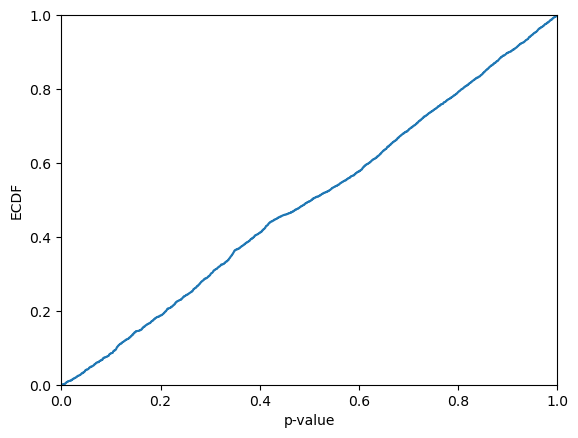

KS-test: 0.0010132423204891204


In [11]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

By default, the conformal classifiers obtained using `WrapClassifier` will compute non-conformity scores using the `hinge` function defined in `crepes.extras`. We could alternatively generate a conformal classifier using the `margin` function, which we imported above:

In [12]:
rf_margin = WrapClassifier(rf.learner)

rf_margin.calibrate(X_cal, y_cal, nc=margin)

display(rf_margin)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

### Mondrian conformal classifiers

To control the error level across different groups of objects of interest, we may use so-called Mondrian conformal classifiers. A Mondrian conformal classifier if formed by providing a function or a `MondrianCategorizer` (defined in `crepes.extras`) as an additional argument, named `mc`, for the `calibrate` method. 

For illustration, we will use the predicted labels of the underlying model to form the categories:

In [13]:
rf_mond = WrapClassifier(rf.learner)
rf_mond.calibrate(X_cal, y_cal, mc=rf_mond.predict)

display(rf_mond)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

We may now form prediction sets for the test objects (using the same categorization of the test objects under the hood):

In [14]:
prediction_sets_mond = rf_mond.predict_set(X_test)

display(prediction_sets_mond)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may also form the categories using a `MondrianCategorizer`, which may be fitted in several different ways. Below we show how to form categories by (equal-sized) binning of the first feature value, using five bins (instead of the default which is 10); note that we need objects to get the threshold values for the categories (bins):

In [15]:
def get_values(X):
    return X[:,0]

mc_scoring = MondrianCategorizer()
mc_scoring.fit(X_cal, f=get_values, no_bins=5)

display(mc_scoring)
rf_mond_scoring = WrapClassifier(rf.learner)
rf_mond_scoring.calibrate(X_cal, y_cal, mc=mc_scoring)

display(rf_mond_scoring)

MondrianCategorizer(fitted=True, f=get_values, no_bins=5)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

We may now form prediction sets for the test objects, again using the same Mondrian categorizer:

In [16]:
prediction_sets_mond_scoring = rf_mond_scoring.predict_set(X_test)

display(prediction_sets_mond_scoring)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

### Class-conditional conformal classifiers

Class-conditional conformal classifiers is a special type of Mondrian conformal classifiers where the categories are defined by actual (and not predicted, as above) class labels. The test objects need special treatment since we do not know to which categories they belong; a non-conformity score (p-value) is generated for each possible class label. Since this is a common type of conformal classifier, and it is a bit tricky to handle the test objects in the above way, the `calibrate` method has a specific option (`class_cond`) to enable it, as shown below:

In [17]:
rf_class_cond = WrapClassifier(rf.learner)

rf_class_cond.calibrate(X_cal, y_cal, class_cond=True)

display(rf_class_cond)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

The prediction sets for the test objects are generated in the usual way:

In [18]:
prediction_sets_class_cond = rf_class_cond.predict_set(X_test)

display(prediction_sets_class_cond)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

### Evaluating the conformal classifiers

Since we have access to the correct class labels for the test set, we can investigate the predictive performance of the conformal classifiers.
Let us start with the standard conformal classifier (which uses the default `hinge` function to compute non-conformity scores):

In [19]:
rf.evaluate(X_test, y_test)

{'error': 0.0404025880661395,
 'avg_c': 0.9610352264557872,
 'one_c': 0.9610352264557872,
 'empty': 0.038964773544212794,
 'ks_test': 0.0012658471604212744,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.6912088394165039}

Above we used the default (95%) confidence level, but we could specify some other:

In [20]:
rf.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.0846872753414809,
 'avg_c': 0.9164629762760604,
 'one_c': 0.9164629762760604,
 'empty': 0.08353702372393962,
 'ks_test': 0.0014393522574334269,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.6677846908569336}

Let us also evaluate the standard conformal classifier that uses the `margin` function to compute non-conformity scores:

In [21]:
rf_margin.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08439971243709565,
 'avg_c': 0.9167505391804457,
 'one_c': 0.9167505391804457,
 'empty': 0.08324946081955428,
 'ks_test': 0.001590942736191051,
 'time_fit': 2.384185791015625e-06,
 'time_evaluate': 0.8434393405914307}

The evaluation of the two Mondrian conformal classifiers (for which we used two different Mondrian categorizers) is done in the same way:

In [22]:
rf_mond.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08914450035945365,
 'avg_c': 0.9120057512580877,
 'one_c': 0.9120057512580877,
 'empty': 0.08799424874191229,
 'ks_test': 5.593471621486094e-05,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.7685756683349609}

In [23]:
rf_mond_scoring.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08339324227174694,
 'avg_c': 0.9176132278936018,
 'one_c': 0.9176132278936018,
 'empty': 0.08238677210639828,
 'ks_test': 9.245027662987211e-05,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.5633783340454102}

Let us also evaluate the class-conditional conformal classifier:

In [24]:
rf_class_cond.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.09144500359453633,
 'avg_c': 0.9095614665708124,
 'one_c': 0.9095614665708124,
 'empty': 0.09043853342918763,
 'ks_test': 7.429100238891395e-05,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 2.2136645317077637}

We may evaluate the conformal classifiers on each class separately. For the standard conformal classifier, we get:

In [25]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.9))
    print("")

Class 1:


{'error': 0.06692607003891049,
 'avg_c': 0.9330739299610895,
 'one_c': 0.9330739299610895,
 'empty': 0.0669260700389105,
 'ks_test': 3.0946574531302674e-10,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.17604637145996094}


Class 2:


{'error': 0.05842391304347827,
 'avg_c': 0.9429347826086957,
 'one_c': 0.9429347826086957,
 'empty': 0.057065217391304345,
 'ks_test': 1.9363640550744776e-56,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.19552159309387207}


Class 3:


{'error': 0.08343409915356714,
 'avg_c': 0.9226118500604595,
 'one_c': 0.9226118500604595,
 'empty': 0.0773881499395405,
 'ks_test': 0.0024108210160489504,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.13633060455322266}


Class 4:


{'error': 0.15583075335397312,
 'avg_c': 0.8441692466460269,
 'one_c': 0.8441692466460269,
 'empty': 0.15583075335397317,
 'ks_test': 1.1504056113176992e-89,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.1463031768798828}


Class 5:


{'error': 0.07702612190221036,
 'avg_c': 0.9229738780977896,
 'one_c': 0.9229738780977896,
 'empty': 0.07702612190221031,
 'ks_test': 5.592538443391781e-21,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.1839449405670166}


Class 6:


{'error': 0.09020902090209026,
 'avg_c': 0.9108910891089109,
 'one_c': 0.9108910891089109,
 'empty': 0.0891089108910891,
 'ks_test': 4.88787792970183e-46,
 'time_fit': 3.337860107421875e-06,
 'time_evaluate': 0.14435482025146484}

As can be observed above, a standard conformal classifier may significantly exceed the error level when considering each class separately. This contrasts to the class-condition conformal classifier:

In [26]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf_class_cond.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.9))
    print("")

Class 1:


{'error': 0.09105058365758756,
 'avg_c': 0.9089494163424124,
 'one_c': 0.9089494163424124,
 'empty': 0.09105058365758754,
 'ks_test': 0.0001858581690487567,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.480088472366333}


Class 2:


{'error': 0.10733695652173914,
 'avg_c': 0.8940217391304348,
 'one_c': 0.8940217391304348,
 'empty': 0.10597826086956522,
 'ks_test': 0.07821095302063885,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.5263075828552246}


Class 3:


{'error': 0.10157194679564696,
 'avg_c': 0.9032648125755743,
 'one_c': 0.9032648125755743,
 'empty': 0.09673518742442563,
 'ks_test': 0.04995278806404535,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.3195760250091553}


Class 4:


{'error': 0.09907120743034059,
 'avg_c': 0.9009287925696594,
 'one_c': 0.9009287925696594,
 'empty': 0.09907120743034056,
 'ks_test': 0.012866228112669556,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.3789956569671631}


Class 5:


{'error': 0.08975217682518422,
 'avg_c': 0.9102478231748158,
 'one_c': 0.9102478231748158,
 'empty': 0.08975217682518419,
 'ks_test': 5.088808613816955e-05,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.5127410888671875}


Class 6:


{'error': 0.05280528052805278,
 'avg_c': 0.9482948294829483,
 'one_c': 0.9482948294829483,
 'empty': 0.0517051705170517,
 'ks_test': 0.0008464549521329398,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.36368417739868164}

### Semi-online conformal classifiers

The above conformal classifiers are fitted once using the provided calibration set. In case we are receiving the correct label for each test object immediately after making a prediction, we may consider the option of employing *online calibration*, i.e., continuously updating the calibration set. This is done by setting `online=True` when calling the methods `predict_p`, `predict_set`, and `evaluate`.

#### Online calibration with an already calibrated conformal classifier

Here we will obtain p-values computed in an online fashion for the above fitted standard conformal classifier. Note that in addition to the test objects, we also need to provide the correct labels.

In [27]:
rf.predict_p(X_test, y_test, online=True)

array([[7.12382545e-02, 1.42401659e-03, 4.90159428e-04, 7.45847495e-03,
        2.18309515e-03, 1.98037996e-03],
       [1.12347260e-04, 4.07636586e-01, 3.05823930e-03, 1.02150784e-03,
        1.10784632e-04, 1.54268756e-03],
       [1.52584633e-03, 3.80601569e-04, 1.98480542e-04, 5.65052745e-04,
        7.41303433e-01, 1.14888673e-03],
       ...,
       [2.68831282e-04, 3.10807302e-04, 5.62649546e-04, 2.17152755e-03,
        9.63450138e-04, 1.97410403e-01],
       [4.61553549e-04, 5.72752086e-04, 4.44550165e-04, 2.89724023e-03,
        4.94855748e-04, 1.10570207e-01],
       [9.82250766e-04, 4.94254144e-04, 4.92979994e-04, 9.92940707e-04,
        6.65843559e-02, 3.27146481e-03]])

In [28]:
rf_class_cond.predict_p(X_test, y_test, online=True)

array([[5.26757071e-02, 3.51253841e-04, 4.35781175e-03, 8.55582874e-03,
        4.32614054e-03, 2.92515154e-03],
       [1.21060677e-04, 2.35660361e-01, 1.18911734e-02, 3.82175834e-03,
        2.64861356e-03, 2.57595924e-03],
       [8.68279739e-04, 1.99223121e-03, 1.45128000e-03, 1.67018875e-03,
        7.32038060e-01, 1.80246458e-03],
       ...,
       [6.05436328e-04, 4.19731028e-04, 3.86819905e-03, 3.63961131e-03,
        8.34501791e-04, 2.95091236e-01],
       [6.18334268e-05, 4.88607026e-04, 2.27753474e-03, 3.37836609e-03,
        6.51029990e-04, 1.38137766e-01],
       [3.53629711e-04, 6.23145846e-05, 3.61793911e-03, 2.25112369e-03,
        6.79539731e-02, 2.04515808e-03]])

Similarly, we can obtain prediction sets based on the p-values computed online, which are compared to the specified level of confidence:

In [29]:
rf_mond.predict_set(X_test, y_test, confidence=0.99, online=True)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [30]:
rf_class_cond.predict_set(X_test, y_test, confidence=0.99, online=True)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when calibrating the conformal classifier. If we would like the original calibration set to be ignored, we can set the `warm_start` option to `False`. Note that few (if any) class labels will be excluded from the initial prediction sets, before we have a sufficiently large calibration set to allow for excluding labels at the specified level of confidence.

In [31]:
rf_mond.predict_set(X_test, y_test, confidence=0.99,
                    online=True, warm_start=False)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [32]:
rf_class_cond.predict_set(X_test, y_test, confidence=0.99, 
                          online=True, warm_start=False)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

Let us take a look at how the p-values for the correct labels are distributed. From both the visual inspection and the Kolmogorov-Smirnov test, we cannot rule out that the p-values are sampled from a uniform distribution. 

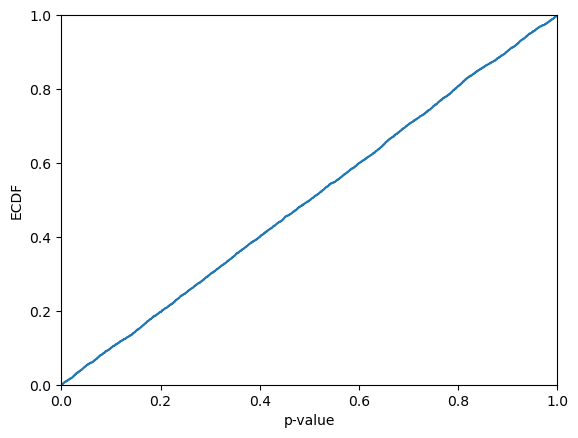

KS-test: 0.27047607586651834


In [33]:
p_values = rf_class_cond.predict_p(X_test, y_test, all_classes=False, 
                                    online=True, warm_start=False)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may also evaluate the conformal classifiers using online calibration, by specifying `online=True` for the `evaluate` method:

In [34]:
rf_mond.evaluate(X_test, y_test, confidence=0.99, online=True)

{'error': 0.008051761322789397,
 'avg_c': 1.0166786484543493,
 'one_c': 0.9794392523364486,
 'empty': 0.004313443565780014,
 'ks_test': 0.15766280695981605,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.7295222282409668}

In [35]:
rf_class_cond.evaluate(X_test, y_test, confidence=0.99, online=True)

{'error': 0.007620416966211407,
 'avg_c': 1.025017972681524,
 'one_c': 0.9676491732566499,
 'empty': 0.00402588066139468,
 'ks_test': 0.08904358923516276,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.663726806640625}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [36]:
rf_mond.evaluate(X_test, y_test, confidence=0.99, online=True, warm_start=False)

{'error': 0.009489575844715992,
 'avg_c': 1.2153846153846153,
 'one_c': 0.9145938173975557,
 'empty': 0.005463695183321351,
 'ks_test': 0.8488051963934213,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.7106227874755859}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the underlying model. 

In [37]:
rf_full = WrapClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500))

rf_full.fit(X_train, y_train)

Let us first initialize the conformal classifier with an empty calibration set, i.e., not specifying any objects or labels for the `calibrate` method (we may still provide a non-conformity function and Mondrian categorizer):

In [38]:
rf_full.calibrate()

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=False)

We may now obtain prediction sets while sequentially adding test objects and labels to the calibration set:

In [39]:
prediction_sets_online = rf_full.predict_set(X_test, y_test, confidence=0.99, online=True)

display(prediction_sets_online)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

Let us take a look at how the p-values for the correct labels are distributed. From both the visual inspection and the Kolmogorov-Smirnov test, we cannot rule out that the p-values are sampled from a uniform distribution. 

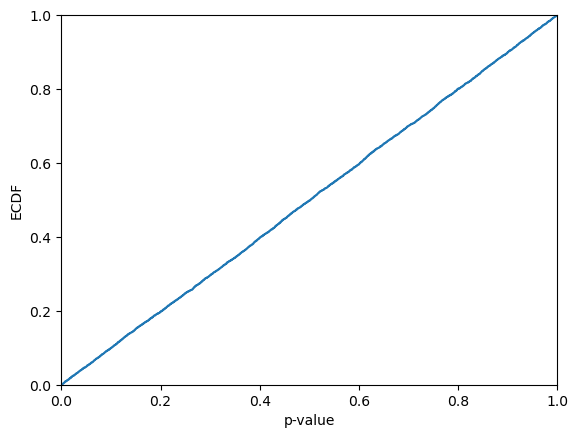

KS-test: 0.9138435032150545


In [40]:
p_values = rf_full.predict_p(X_test, y_test, all_classes=False, online=True)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may also evaluate the conformal classifier using online calibration, by specifying `online=True` for the `evaluate` method:

In [41]:
rf_full.evaluate(X_test, y_test, confidence=0.99, online=True)

{'error': 0.010064701653486718,
 'avg_c': 1.0290438533429187,
 'one_c': 0.9813084112149533,
 'empty': 0.006901509705248023,
 'ks_test': 0.8529608925186685,
 'time_fit': 1.430511474609375e-06,
 'time_evaluate': 0.7724449634552002}

### Out-of-bag calibration

For conformal classifiers that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal classifiers, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal classifiers based on out-of-bag predictions rarely fail to meet the coverage requirements.

#### Standard conformal classifiers with out-of-bag calibration

Let us first generate a model from the full training set, making sure the learner has an attribute `oob_decision_function_`, which e.g. is the case for a `RandomForestClassifier` if `oob_score` is set to `True` when created.

In [42]:
learner_full = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True)

rf = WrapClassifier(learner_full)

rf.fit(X_train, y_train)

We may now obtain a standard conformal classifier using OOB predictions:

In [43]:
rf.calibrate(X_train, y_train, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

... and use it to get prediction sets for the test set:

In [44]:
prediction_sets_oob = rf.predict_set(X_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

#### Mondrian conformal classifiers with out-of-bag calibration

Using out-of-bag calibration works equally well for Mondrian conformal classifiers:

In [45]:
rf.calibrate(X_train, y_train, mc=mc_scoring, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

Prediction sets for the test objects are obtained in the usual way:

In [46]:
prediction_sets_mond_oob = rf.predict_set(X_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may of course evaluate the Mondrian conformal classifier using out-of-bag predictions too:

In [47]:
results = rf.evaluate(X_test, y_test, confidence=0.99)

display(results)

{'error': 0.007620416966211407,
 'avg_c': 1.0005751258087707,
 'one_c': 0.99137311286844,
 'empty': 0.00402588066139468,
 'ks_test': 3.5417834161346386e-20,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.7025315761566162}

#### Class-conditional conformal classifiers with out-of-bag calibration

Unsurprisingly, since a class-conditional conformal classifier is a special type of Mondrian conformal classifier, we can use out-of-bag calibration for them too:

In [48]:
rf.calibrate(X_train, y_train, class_cond=True, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

Prediction sets for the test objects are obtained in the usual way:

In [49]:
prediction_sets_class_cond_oob = rf.predict_set(X_test)

display(prediction_sets_class_cond_oob)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

Finally, for completeness, we show that a class-conditional conformal classifier formed using out-of-bag calibration may be evaluated too:

In [50]:
results = rf.evaluate(X_test, y_test, confidence=0.99)

display(results)

{'error': 0.006326383896477328,
 'avg_c': 1.0063263838964773,
 'one_c': 0.987922358015816,
 'empty': 0.002875629043853343,
 'ks_test': 4.660862606055584e-22,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 2.5540473461151123}

Let us also check the performance for the classes separately:

In [51]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.99))
    print("")

Class 1:


{'error': 0.007003891050583633,
 'avg_c': 0.9937743190661479,
 'one_c': 0.9937743190661479,
 'empty': 0.0062256809338521405,
 'ks_test': 6.965109765115711e-10,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.5595159530639648}


Class 2:


{'error': 0.008152173913043459,
 'avg_c': 1.0264945652173914,
 'one_c': 0.9694293478260869,
 'empty': 0.0020380434782608695,
 'ks_test': 3.818481342223841e-11,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.60813307762146}


Class 3:


{'error': 0.0048367593712213,
 'avg_c': 1.0060459492140266,
 'one_c': 0.9939540507859734,
 'empty': 0.0,
 'ks_test': 2.542875384301272e-09,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.3685946464538574}


Class 4:


{'error': 0.006191950464396245,
 'avg_c': 1.001031991744066,
 'one_c': 0.9907120743034056,
 'empty': 0.0041279669762641896,
 'ks_test': 3.929046208555481e-05,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.4269828796386719}


Class 5:


{'error': 0.0026791694574681557,
 'avg_c': 1.0053583389149363,
 'one_c': 0.9906229068988613,
 'empty': 0.0020093770931011385,
 'ks_test': 1.035676366633335e-13,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.5986742973327637}


Class 6:


{'error': 0.00990099009900991,
 'avg_c': 0.9955995599559956,
 'one_c': 0.9933993399339934,
 'empty': 0.005500550055005501,
 'ks_test': 0.043879710873837574,
 'time_fit': 7.152557373046875e-07,
 'time_evaluate': 0.39780497550964355}

## Conformal regressors

### Importing and splitting a regression dataset

Let us import a dataset from [www.openml.org](https://www.openml.org) and min-max normalize the targets; the latter is not really necessary, but useful, allowing to directly compare the size of a prediction interval to the whole target range, which becomes 1.0 in this case.

In [52]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### Standard conformal regressors

Let us create a conformal regressor through a `WrapRegressor` object, using a random forest that is fitted in the usual way (using the proper training set only), before or after being wrapped:

In [54]:
rf = WrapRegressor(RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True))

rf.fit(X_prop_train, y_prop_train)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=False)

We will use the the calibration set to calibrate the conformal regressor; note that the `calibrate` method has been added to the wrapped learner, in addition to the standard `fit`and `predict` methods. 

In [55]:
rf.calibrate(X_cal, y_cal)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

We may now obtain prediction intervals for the test set using the new method `predict_int`; 
here using a confidence level of 99%.

In [56]:
intervals = rf.predict_int(X_test, confidence=0.99)

display(intervals)

array([[ 0.00432563,  0.1509834 ],
       [-0.02212541,  0.12453236],
       [ 0.00705543,  0.15371321],
       ...,
       [-0.03614123,  0.11051654],
       [-0.00408622,  0.14257155],
       [-0.046295  ,  0.10036277]])

We may request that the intervals are cut to exclude impossible values, in this case below 0 and above 1; below we also use the default 
confidence level (95%), which further tightens the intervals.

In [57]:
intervals_std = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_std)

array([[0.04431751, 0.11099151],
       [0.01786648, 0.08454048],
       [0.04704732, 0.11372132],
       ...,
       [0.00385065, 0.07052465],
       [0.03590566, 0.10257966],
       [0.        , 0.06037088]])

If we want to obtain the p-values for the correct labels, we can use `predict_p`, and in addition to the point predictions also provide the correct labels:

In [58]:
p_values = rf.predict_p(X_test, y_test)
display(p_values)

array([0.58226226, 0.29829358, 0.42156858, ..., 0.13607924, 0.5801904 ,
       0.6795197 ])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal regressors, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

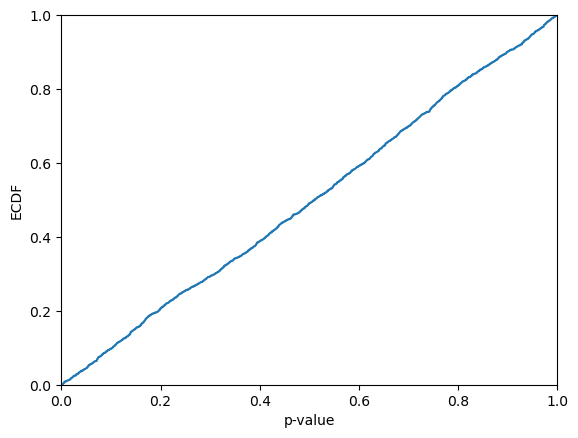

KS-test: 0.011247230215991305


In [59]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Accessing the wrapped learner 

As shown above, we have access directly to some methods of the wrapped learner, e.g., through the `fit` and `predict` methods. We can also access the wrapped learner directly by the following:

In [60]:
learner_prop = rf.learner

This may be useful, e.g., in case a fitted wrapped learner is to be re-used in another conformal regressor, as we will see below.

### Normalized conformal regressors

The above intervals are not normalized, i.e., they are all of the same size (at least before they are cut). We could make the intervals more informative through normalization using difficulty estimates; 
more difficult instances will be assigned wider intervals. We can use a `DifficultyEstimator`, as imported from `crepes.extras`,  for this purpose. It can be used to estimate the difficulty by using k-nearest neighbors in three different ways: i) by the (Euclidean) distances to the nearest neighbors, ii) by the standard deviation of the targets of the nearest neighbors, and iii) by the absolute errors of the k nearest neighbors. 

A small value (beta) is added to the estimates, which may be given through a (named) argument to the `fit` method; we will just use the default for this, i.e., `beta=0.01`. In order to make the beta value have the same effect across different estimators, we may opt for normalizing the difficulty estimates (using min-max scaling) by setting `scaler=True`. It should be noted that this comes with a computational cost; for estimators based on the k-nearest neighbor, a leave-one-out protocol is employed to find the minimum and maximum distances that are used by the scaler.

We will first consider just using the first option (distances to the k-nearest neighbors) to produce normalized conformal regressors, using the default number of nearest neighbors, i.e., `k=25`.

In [61]:
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

We create a new (normalized) conformal regressor re-using the underlying (already fitted) learner of the previous conformal regressor, and calibrate it using the calibration objects and labels together the difficulty estimator:

In [62]:
rf_norm_knn_dist = WrapRegressor(learner_prop)

rf_norm_knn_dist.calibrate(X_cal, y_cal, de=de_knn)

display(rf_norm_knn_dist)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

To obtain prediction intervals, we just have to provide test objects to the `predict_int` method, as the difficulty estimates will be computed by the incorporated difficulty estimator: 

In [63]:
intervals_norm_knn_dist = rf_norm_knn_dist.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_dist)

array([[0.06030177, 0.09500725],
       [0.02350499, 0.07890197],
       [0.05643085, 0.10433779],
       ...,
       [0.00218195, 0.07219336],
       [0.01759727, 0.12088805],
       [0.        , 0.06153991]])

Alternatively, we could estimate the difficulty using the standard deviation of the targets of the nearest neighbors; we specify this by providing the targets too to the `fit` method:

In [64]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

rf_norm_knn_std = WrapRegressor(learner_prop)

rf_norm_knn_std.calibrate(X_cal, y_cal, de=de_knn_std)

display(rf_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

We obtain the prediction intervals in the same way as before:

In [65]:
intervals_norm_knn_std = rf_norm_knn_std.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_std)

array([[0.05751344, 0.09779558],
       [0.02813811, 0.07426884],
       [0.05944059, 0.10132805],
       ...,
       [0.01194057, 0.06243473],
       [0.05001645, 0.08846887],
       [0.01819191, 0.03587586]])

A third option is to use (absolute) residuals for the reference objects. For a model that overfits the training data, it can be a good idea to use a separate set of (reference) objects and labels from which the residuals could be calculated, rather than using the original training data. Since we in this case have trained a random forest, we opt for estimating the residuals by using the out-of-bag predictions for the training instances, where the latter are stored in `oob_prediction_` of the underlying lerner (as a consequence of setting `oob_score=True` for the `RandomForestRegressor` above.)

To inform the `fit` method that this is what we want to do, we provide a value for `residuals`, instead of `y` as we did above for the option to use the (standard deviation of) the targets.

In [66]:
residuals_prop_oob = y_prop_train - rf.learner.oob_prediction_

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_prop_oob, scaler=True)

display(de_knn_res)

rf_norm_knn_res = WrapRegressor(learner_prop)

rf_norm_knn_res.calibrate(X_cal, y_cal, de=de_knn_res)

display(rf_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

Let us also generate the prediction intervals:

In [67]:
intervals_norm_knn_res = rf_norm_knn_res.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_res)

array([[0.05024389, 0.10506514],
       [0.03399668, 0.06841028],
       [0.06025162, 0.10051702],
       ...,
       [0.00827465, 0.06610065],
       [0.05932399, 0.07916133],
       [0.00708803, 0.04697973]])

In case we have trained an ensemble model, like a `RandomForestRegressor`, we could alternatively request `DifficultyEstimator` to estimate the difficulty by the variance of the predictions of the constituent models. This requires us to provide the trained model `learner` as input to `fit`, assuming that `learner.estimators_` is a collection of base models, each implementing the `predict` method; this holds e.g., for `RandomForestRegressor`. A set of objects (`X`) has to be provided only if we employ scaling (`scaler=True`).

In [68]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=learner_prop, scaler=True)

display(de_var)

rf_norm_var = WrapRegressor(learner_prop)

rf_norm_var.calibrate(X_cal, y_cal, de=de_var)

display(rf_norm_var)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

The prediction intervals are obtained in the usual way:

In [69]:
intervals_norm_var = rf_norm_var.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_var)

array([[0.05858419, 0.09672483],
       [0.03407071, 0.06833625],
       [0.03113766, 0.12963098],
       ...,
       [0.02119189, 0.05318341],
       [0.04789142, 0.0905939 ],
       [0.01277108, 0.04129668]])

Let us also take a look at how the p-values are distributed. Again, they appear to be approximaly uniformly distributed, but this is not guaranteed, and with the Kolmogorov-Smirnov test one may be able to rule out that the p-values are sampled from a uniform distribution.

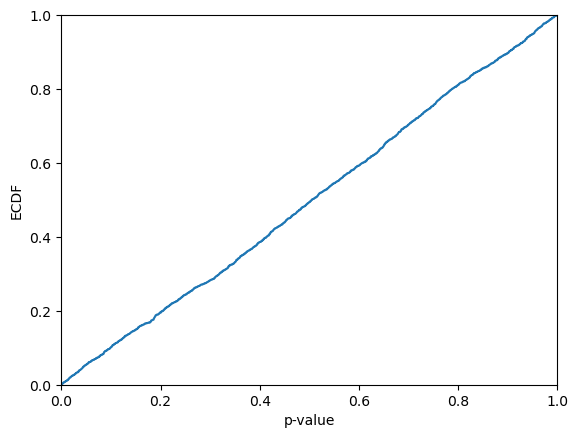

KS-test: 0.00019458318494431685


In [70]:
p_values = rf_norm_var.predict_p(X_test, y_test)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Mondrian conformal regressors

An alternative way of generating prediction intervals of varying size
is to divide the object space into non-overlapping so-called Mondrian categories.
A Mondrian conformal regressor is formed by providing a function or a `MondrianCategorizer` (defined in `crepes.extras`) as an additional argument, named `mc`, for the `calibrate` method. 

Here we employ a `MondrianCategorizer`; it may be fitted in several different ways, and below we show how to form categories by binning of the difficulty estimates into 20 bins, using one of the previously fitted difficulty estimators. 

In [71]:
mc = MondrianCategorizer()

mc.fit(X_cal, de=de_var, no_bins=20)

display(mc)

rf_mond = WrapRegressor(learner_prop)

rf_mond.calibrate(X_cal, y_cal, mc=mc)

display(rf_mond)

MondrianCategorizer(fitted=True, de=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False), no_bins=20)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=True))

Prediction intervals for the test instances are obtained in the usual way:

In [72]:
intervals_mond = rf_mond.predict_int(X_test, y_min=0, y_max=1)

display(intervals_mond)

array([[0.05467909, 0.10062993],
       [0.03241103, 0.06999593],
       [0.03447095, 0.12629769],
       ...,
       [0.02014533, 0.05422997],
       [0.04138478, 0.09710054],
       [0.0117465 , 0.04232127]])

Let us also take a look at how the p-values are distributed. Again, they may appear to be approximaly uniformly distributed, but this is not guaranteed, and with the Kolmogorov-Smirnov test one may be able to rule out that the p-values are sampled from a uniform distribution.

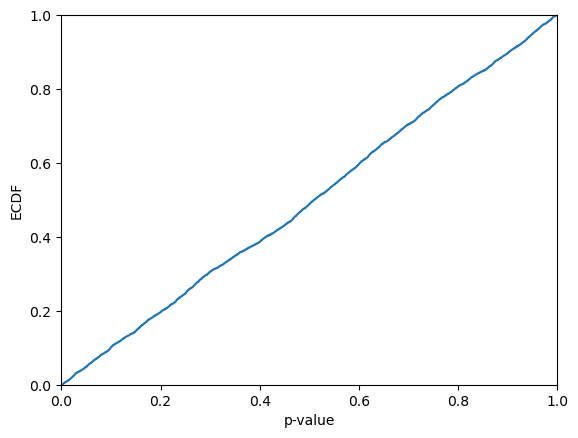

KS-test: 0.00036458705973426564


In [73]:
p_values = rf_mond.predict_p(X_test, y_test)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Investigating the prediction intervals

Let us first put all the intervals in a dictionary.

In [74]:
prediction_intervals = {
    "Std CR":intervals_std,
    "Norm CR knn dist":intervals_norm_knn_dist,
    "Norm CR knn std":intervals_norm_knn_std,
    "Norm CR knn res":intervals_norm_knn_res,
    "Norm CR var":intervals_norm_var,
    "Mond CR":intervals_mond,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [75]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9553,0.0647,0.0667
Norm CR knn dist,0.9550,0.0615,0.0513
Norm CR knn std,0.9497,0.0601,0.0471
Norm CR knn res,0.9510,0.0570,0.0447
Norm CR var,0.9458,0.0579,0.0322
Mond CR,0.9576,0.0569,0.0376
Mean,0.9524,0.0597,0.0466


Let us look at the distribution of the interval sizes.

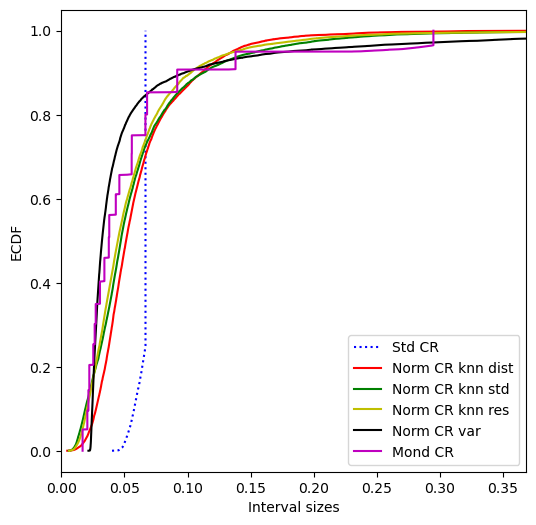

In [76]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Evaluating the conformal regressors

Let us put the six above conformal regressors in a dictionary:

In [77]:
all_methods = {
    "Std CR": rf,
    "Norm CR knn dist": rf_norm_knn_dist,
    "Norm CR knn std": rf_norm_knn_std,
    "Norm CR knn res": rf_norm_knn_res,
    "Norm CR var" : rf_norm_var,
    "Mond CR": rf_mond
}

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default.

In [78]:
confidence_levels = [0.9,0.95,0.99]

names = list(all_methods.keys())

all_results = {}

for confidence in confidence_levels:
    for name in names:
        all_results[(name,confidence)] = all_methods[name].evaluate(
            X_test, y=y_test, confidence=confidence, 
            y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [names,confidence_levels]), index=list(list(
    all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

display(results_df.round(4))

Std CR                 Norm CR knn dist                  \
                 0.90    0.95    0.99             0.90    0.95    0.99   
error          0.1000  0.0496  0.0102           0.1026  0.0495  0.0088   
eff_mean       0.0420  0.0618  0.1220           0.0442  0.0594  0.0969   
eff_med        0.0422  0.0632  0.1224           0.0366  0.0494  0.0807   
ks_test        0.5164  0.5164  0.5164           0.8766  0.8766  0.8766   
time_fit       0.0002  0.0002  0.0002           0.0001  0.0001  0.0001   
time_evaluate  0.1422  0.1282  0.1504           0.1747  0.1717  0.1950   

              Norm CR knn std                 Norm CR knn res                  \
                         0.90    0.95    0.99            0.90    0.95    0.99   
error                  0.1010  0.0515  0.0084          0.1011  0.0498  0.0094   
eff_mean               0.0454  0.0597  0.0969          0.0429  0.0568  0.0957   
eff_med                0.0353  0.0467  0.0772          0.0335  0.0445  0.0762   
ks_test                0.8060  0.8060  0.8060          0.8111  0.8111  0.8111   
time_fit               0.0001  0.0001  0.0001          0.0001  0.0001  0.0001   
time_evaluate          0.1382  0.1296  0.1591          0.1647  0.1641  0.1686   

              Norm CR var                 Mond CR                  
                     0.90    0.95    0.99    0.90    0.95    0.99  
error              0.0997  0.0527  0.0105  0.0989  0.0485  0.0090  
eff_mean           0.0474  0.0583  0.0845  0.0414  0.0530  0.0925  
eff_med            0.0259  0.0324  0.0496  0.0276  0.0350  0.0576  
ks_test            0.3080  0.3080  0.3080  0.1259  0.1259  0.1259  
time_fit           0.0001  0.0001  0.0001  0.0005  0.0005  0.0005  
time_evaluate      0.1342  0.1298  0.1303  0.0735  0.0792  0.0805

### Semi-online conformal regressors

Similar to semi-online conformal classifiers, we may consider employing *online calibration* also for conformal regressors, i.e., continuously updating the calibration set after making each prediction. This is achieved by setting `online=True` when calling the methods `predict_p`, `predict_int` and `evaluate`. 

#### Online calibration with calibrated conformal regressors

Here we will obtain p-values computed in an online fashion for some of the above calibrated conformal regressors. Note that in addition to the test objects, we also need to provide the correct labels.

array([0.58198376, 0.29809299, 0.42178719, ..., 0.13470887, 0.57332177,
       0.67954364])

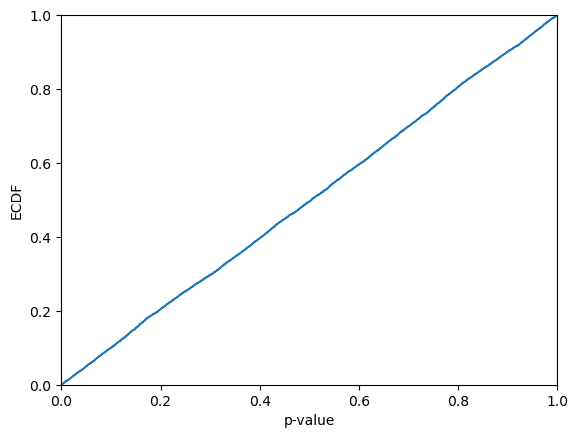

KS-test: 0.5055890820835738


In [79]:
p_values = rf.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

array([0.42868216, 0.3064395 , 0.37436168, ..., 0.19469389, 0.76232103,
       0.75206161])

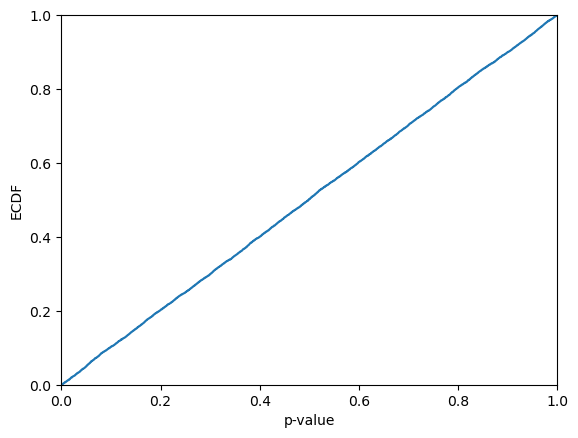

KS-test: 0.8751126653645003


In [80]:
p_values = rf_norm_knn_dist.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

array([0.66062829, 0.30086454, 0.74103721, ..., 0.04789733, 0.69831211,
       0.60161052])

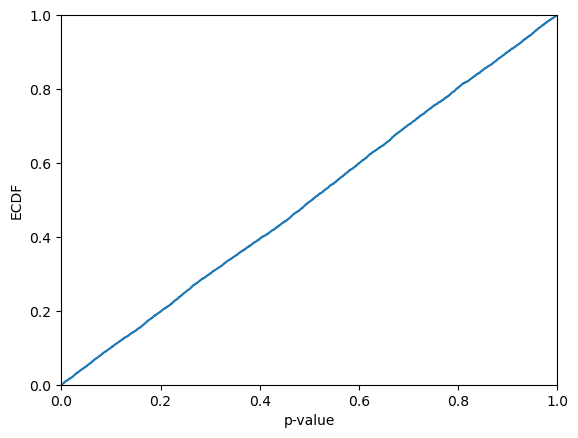

KS-test: 0.23618933740362713


In [81]:
p_values = rf_mond.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

Similarly, we can obtain prediction intervals using online calibration:

In [82]:
rf.predict_int(X_test, y_test, online=True)

array([[ 0.04431751,  0.11099151],
       [ 0.01786648,  0.08454048],
       [ 0.04704732,  0.11372132],
       ...,
       [ 0.0054869 ,  0.06888841],
       [ 0.03754191,  0.10094342],
       [-0.00466687,  0.05873464]])

In [83]:
rf_norm_knn_dist.predict_int(X_test, y_test, online=True)

array([[ 0.06030177,  0.09500725],
       [ 0.02350499,  0.07890197],
       [ 0.05643085,  0.10433779],
       ...,
       [ 0.0033792 ,  0.0709961 ],
       [ 0.01936363,  0.11912169],
       [-0.00629198,  0.06035975]])

In [84]:
rf_mond.predict_int(X_test, y_test, online=True)

array([[0.05467909, 0.10062993],
       [0.03241103, 0.06999593],
       [0.03447095, 0.12629769],
       ...,
       [0.02078338, 0.05359192],
       [0.0442988 , 0.09418652],
       [0.01263441, 0.04143335]])

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when fitting the conformal regressor. We may set the `warm_start` option to `False`, if we would like to ignore the original calibration set. Note that the initial predictions tend to be very (maximally) wide, before we have a sufficiently large calibration set to allow for providing tighter intervals at the specified level of confidence.

In [85]:
rf.predict_int(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
               online=True, warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 0.10942014],
       [0.        , 0.14147515],
       [0.        , 0.09926637]])

In [86]:
rf_norm_knn_dist.predict_int(X_test, y_test, confidence=0.99, 
                             y_min=0, y_max=1, 
                             online=True, warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 0.09462578],
       [0.        , 0.15398354],
       [0.        , 0.08365213]])

In [87]:
rf_mond.predict_int(X_test, y_test, confidence=0.99,
                    y_min=0, y_max=1, 
                    online=True, warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.01020721, 0.06416809],
       [0.03216402, 0.1063213 ],
       [0.00412457, 0.0499432 ]])

We may also evaluate the conformal regressors using online calibration, by specifying `online=True` for the `evaluate` method:

In [88]:
rf.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, online=True)

{'error': 0.010178587952253126,
 'eff_mean': 0.1220059723609381,
 'eff_med': 0.12243605455737837,
 'ks_test': 0.516378414590601,
 'time_fit': 0.00020194053649902344,
 'time_evaluate': 0.13545536994934082}

In [89]:
rf_norm_knn_dist.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                          online=True)

{'error': 0.008790598686036821,
 'eff_mean': 0.0969143763897545,
 'eff_med': 0.08066956341773956,
 'ks_test': 0.8766458617832448,
 'time_fit': 8.702278137207031e-05,
 'time_evaluate': 0.16788291931152344}

In [90]:
rf_mond.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                 online=True)

{'error': 0.008975663921532373,
 'eff_mean': 0.092468876423132,
 'eff_med': 0.057647180327868905,
 'ks_test': 0.1258970152170158,
 'time_fit': 0.0004749298095703125,
 'time_evaluate': 0.07657456398010254}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [91]:
rf_norm_knn_dist.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                          online=True, warm_start=False)

{'error': 0.006477283242342979,
 'eff_mean': 0.10174169713301699,
 'eff_med': 0.0848037507763884,
 'ks_test': 0.11767146471046397,
 'time_fit': 8.702278137207031e-05,
 'time_evaluate': 0.1000823974609375}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the underlying model. 

In [92]:
rf_full = WrapRegressor(RandomForestRegressor(n_jobs=-1, n_estimators=500,
                                              oob_score=True))

rf_full.fit(X_train, y_train)

Let us first initialize the conformal regressor with an empty calibration set, i.e., not specifying any objects or labels for the `calibrate` method (as we will see further below, we may still provide other parameters such as difficulty estimator, Mondrian categorizer, etc.):

In [93]:
rf_full.calibrate()

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=False)

We may now obtain prediction intervals while sequentially updating the calibration set:

In [94]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.0178809 , 0.05935522],
       [0.05063494, 0.09210926],
       [0.00682944, 0.04830376]])

If we provide also a difficulty estimator to `calibrate`, we will obtain a normalized conformal regressor:

In [95]:
de_var = DifficultyEstimator()
de_var.fit(X=X_train, learner=rf_full.learner, scaler=True)

rf_full.calibrate(de=de_var)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=False)

Now we get the intervals in the usual way:

In [96]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02401128, 0.05322483],
       [0.05327082, 0.08947339],
       [0.0131407 , 0.04199251]])

We get a Mondrian regressor by providing a Mondrian categorizer to `calibrate`:

In [97]:
mc = MondrianCategorizer()
mc.fit(X_cal, de=de_var, no_bins=10)

rf_full.calibrate(mc=mc)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=False)

We use the same call again to get the intervals from the Mondrian regressor:

In [98]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02483413, 0.05240198],
       [0.04927617, 0.09346803],
       [0.01378268, 0.04135053]])

Let us investigate the coverage and prediction interval size for each category (here limiting the lower and upper bounds of the intervals):

In [99]:
prediction_intervals = rf_full.predict_int(X_test, y_test, y_min=0, 
                                           y_max=1, confidence=0.9, online=True)
number = []
coverage = []
size = []

bins_test = mc.apply(X_test)

for c in range(len(mc.bin_thresholds)-1):
    selection = bins_test == c
    number.append(np.sum(selection))
    coverage.append(np.sum(
        (prediction_intervals[selection,0] <= y_test[selection]) & \
        (y_test[selection] <= prediction_intervals[selection,1]))/np.sum(selection))
    size.append(np.sum(prediction_intervals[selection,1]-\
                       prediction_intervals[selection,0])/np.sum(selection))

df = pd.DataFrame({"Number":number, "Coverage":coverage, "Size":size})
df.round(4)

,Number,Coverage,Size
0,178,0.9213,0.0657
1,493,0.9047,0.0337
2,643,0.9160,0.0325
3,800,0.9138,0.0306
4,930,0.9032,0.0299
5,1229,0.9056,0.0302
6,1211,0.9075,0.0360
7,1614,0.8934,0.0381
8,2018,0.9054,0.0500
9,1691,0.8965,0.1130


Let us investigate also the p-values:

array([0.65972588, 0.13878553, 0.87155344, ..., 0.06198063, 0.5857074 ,
       0.61964411])

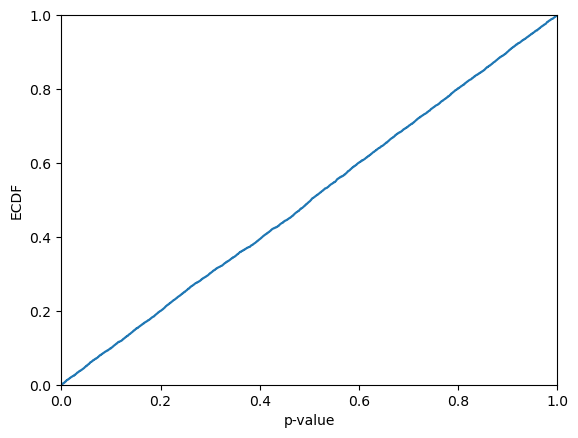

KS-test: 0.27460617882907834


In [100]:
p_values = rf_full.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may also evaluate the conformal regressor using online calibration, by specifying `online=True` for the `evaluate` method:

In [101]:
rf_full.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, online=True)

{'error': 0.008235402979550277,
 'eff_mean': 0.17411042132140828,
 'eff_med': 0.06522391501639344,
 'ks_test': 0.061994601898437085,
 'time_fit': 1.0251998901367188e-05,
 'time_evaluate': 0.08041143417358398}

### Out-of-bag calibration

For conformal regressors that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal regressors, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal regressors based on out-of-bag predictions rarely fail to meet the coverage requirements.

#### Standard conformal regressors with out-of-bag calibration

Let us first generate a model from the full training set, making sure the learner has an attribute `oob_prediction_`, which e.g. is the case for a `RandomForestRegressor` if `oob_score` is set to `True` when created.

In [102]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True)

rf = WrapRegressor(learner_full)

rf.fit(X_train, y_train)

We may now obtain a standard conformal regressor using OOB predictions:

In [103]:
rf.calibrate(X_train, y_train, oob=True)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

... and apply it using the point predictions of the full model.

In [104]:
intervals_std_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_std_oob)

array([[0.04266303, 0.10568848],
       [0.01798263, 0.08100809],
       [0.04546086, 0.10848631],
       ...,
       [0.00708747, 0.07011292],
       [0.03904191, 0.10206736],
       [0.        , 0.05911262]])

#### Normalized conformal regressors with out-of-bag calibration

We may also generate normalized conformal regressors from the OOB predictions. The `DifficultyEstimator` can be used also for this purpose; for the k-nearest neighbor approaches, the difficulty of each object in the training set will be computed using a leave-one-out procedure, while for the variance-based approach the out-of-bag predictions will be employed. 

By setting `oob=True`, we inform the `fit` method that we may request difficulty estimates for the provided set of objects; these will be retrieved by not providing any objects when calling the `apply` method.

Let us start with the k-nearest neighbor approach using distances only.

In [105]:
de_knn_dist_oob = DifficultyEstimator()

de_knn_dist_oob.fit(X=X_train, scaler=True, oob=True)

display(de_knn_dist_oob)

rf.calibrate(X_train, y_train, de=de_knn_dist_oob, oob=True)

display(rf)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

We may then apply the normalized conformal OOB regressor to the test set, as usual:

In [106]:
sigmas_test_knn_dist_oob = de_knn_dist_oob.apply(X_test)

intervals_norm_knn_dist_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_dist_oob)

array([[0.05573182, 0.09261969],
       [0.0183875 , 0.08060322],
       [0.04998982, 0.10395736],
       ...,
       [0.        , 0.07982535],
       [0.01039599, 0.13071329],
       [0.        , 0.06170583]])

For completeness, we will illustrate the use of out-of-bag calibration for the remaining approaches too. For k-nearest neighbors with labels, we do the following:

In [107]:
de_knn_std_oob = DifficultyEstimator()

de_knn_std_oob.fit(X=X_train, y=y_train, scaler=True, oob=True)

display(de_knn_std_oob)

rf.calibrate(X_train, y_train, de=de_knn_std_oob, oob=True)

display(rf)

intervals_norm_knn_std_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_std_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.05331876, 0.09503276],
       [0.02445888, 0.07453184],
       [0.05440063, 0.09954654],
       ...,
       [0.01273307, 0.06446732],
       [0.04964271, 0.09146657],
       [0.01963824, 0.03556155]])

A third option is to use k-nearest neighbors with (OOB) residuals:

In [108]:
residuals_oob = y_train - learner_full.oob_prediction_

de_knn_res_oob = DifficultyEstimator()

de_knn_res_oob.fit(X=X_train, residuals=residuals_oob, scaler=True, oob=True)

display(de_knn_res_oob)

rf.calibrate(X_train, y_train, de=de_knn_res_oob, oob=True)

display(rf)

intervals_norm_knn_res_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_knn_res_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.0527948 , 0.09555671],
       [0.03636704, 0.06262368],
       [0.06107297, 0.09287421],
       ...,
       [0.01433576, 0.06286463],
       [0.05793811, 0.08317117],
       [0.00844388, 0.04675591]])

A fourth and final option for the normalized conformal regressors is to use variance as a difficulty estimate. We then leave labels and residuals out, but provide an (ensemble) learner. In contrast to when `oob=False`, we are here required to provide the (full) training set, from which the variance of the out-of-bag predictions will be computed. When applied to the test set, the full ensemble model will not be used to obtain the difficulty estimates, but instead a subset of the constituent models is used, following what could be seen as post hoc assignment of each test instance to a bag.      

In [109]:
de_var_oob = DifficultyEstimator()

de_var_oob.fit(X=X_train, learner=learner_full, scaler=True, oob=True)

display(de_var_oob)

rf.calibrate(X_train, y_train, de=de_var_oob, oob=True)

display(rf)

intervals_norm_var_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_norm_var_oob)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.05497132, 0.09338019],
       [0.03009186, 0.06889886],
       [0.05537115, 0.09857603],
       ...,
       [0.01980171, 0.05739868],
       [0.04727714, 0.09383214],
       [0.00907835, 0.04612144]])

#### Mondrian conformal regressors with out-of-bag calibration

We may form the categories using the difficulty estimator obtained from the OOB predictions. We here consider the difficulty estimates produced by the fourth above option (using variance) only. 

In [110]:
mc_oob = MondrianCategorizer()

mc_oob.fit(de=de_var_oob, oob=True, no_bins=20)

display(mc_oob)

rf.calibrate(X_train, y_train, mc=mc_oob, oob=True)

display(rf)

MondrianCategorizer(fitted=True, de=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=True), no_bins=20)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=True))

Let us generate prediction intervals:

In [111]:
intervals_mond_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_mond_oob)

array([[0.05479904, 0.09355247],
       [0.03011864, 0.06887208],
       [0.05064936, 0.10329782],
       ...,
       [0.02101589, 0.05618451],
       [0.03805054, 0.10305874],
       [0.01102719, 0.0441726 ]])

### Investigating the OOB prediction intervals

In [112]:
prediction_intervals = {
    "Std CR OOB":intervals_std_oob,
    "Norm CR knn dist OOB":intervals_norm_knn_dist_oob,
    "Norm CR knn std OOB":intervals_norm_knn_std_oob,
    "Norm CR knn res OOB":intervals_norm_knn_res_oob,
    "Norm CR var OOB":intervals_norm_var_oob,
    "Mond CR OOB":intervals_mond_oob,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [113]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR OOB,0.9519,0.0614,0.0630
Norm CR knn dist OOB,0.9672,0.0672,0.0554
Norm CR knn std OOB,0.9480,0.0562,0.0439
Norm CR knn res OOB,0.9361,0.0492,0.0387
Norm CR var OOB,0.9477,0.0493,0.0375
Mond CR OOB,0.9491,0.0518,0.0331
Mean,0.9500,0.0558,0.0453


Let us look at the distribution of the interval sizes.

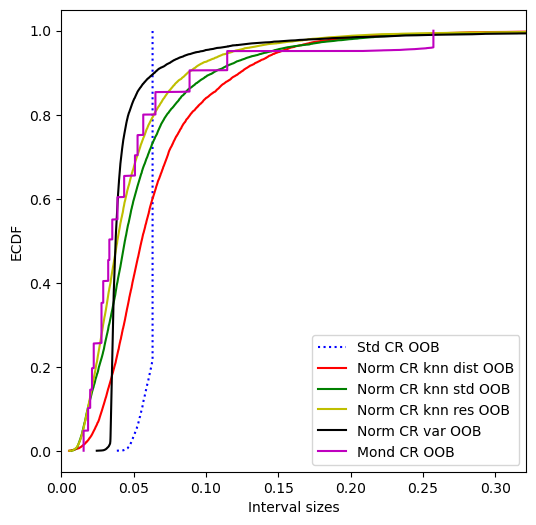

In [114]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR OOB"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

## Conformal predictive systems

### Creating and fitting conformal predictive systems

Conformal predictive systems are created through the `WrapRegressor` class in the same way as conformal regressors. We specify that a conformal predictive system, rather than a conformal regressor, should be formed by providing `cps=True` when calling the `calibrate` method (default is `cps=False`).

Let us start by generating standard and normalized conformal predictive systems (CPS), using the previously fitted `learner_prop` and difficulty estimator `de_var`, as well two conformal predictive systems relying on out-of-bag predictions, using the previously fitted `learner_full` with and without normalization, in the former case using the difficulty estimator `de_var_oob`.

In [115]:
cps_std = WrapRegressor(learner_prop)

cps_std.calibrate(X_cal, y_cal, cps=True)

display(cps_std)

cps_norm = WrapRegressor(learner_prop).calibrate(X_cal, y_cal, de=de_knn_std, 
                                                 cps=True)
display(cps_norm)

cps_std_oob = WrapRegressor(learner_full).calibrate(X_train, y_train, oob=True,
                                                    cps=True)
display(cps_std_oob)

cps_norm_oob = WrapRegressor(learner_full).calibrate(X_train, y_train, 
                                                     de=de_var_oob, oob=True, cps=True)
display(cps_norm_oob)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False))

Let us also create some Mondrian CPS, but in contrast to the Mondrian conformal regressors above, we here form the categories through binning of the predictions rather than binning of the difficulty estimates. We also show how we still may use the latter to obtain a normalized CPS for each category (bin).

In [116]:
mc_p = MondrianCategorizer()

mc_p.fit(X_cal, f=learner_prop.predict, no_bins=5)

cps_mond_std = WrapRegressor(learner_prop)
cps_mond_std.calibrate(X_cal, y_cal, mc=mc_p, cps=True)

display(cps_mond_std)

cps_mond_norm = WrapRegressor(learner_prop)
cps_mond_norm.calibrate(X_cal, y_cal, de=de_knn_std, mc=mc_p, cps=True)

display(cps_mond_norm)

mc_p_oob = MondrianCategorizer()
mc_p_oob.fit(learner=learner_full, oob=True, no_bins=5)

display(mc_p_oob)

cps_mond_std_oob = WrapRegressor(learner_full)
cps_mond_std_oob.calibrate(X_train, y_train, mc=mc_p_oob, oob=True, cps=True)

display(cps_mond_std_oob)

cps_mond_norm_oob = WrapRegressor(learner_full)
cps_mond_norm_oob.calibrate(X_train, y_train, de=de_var_oob, mc=mc_p_oob, oob=True, cps=True)

display(cps_mond_norm_oob)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=True))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True))

MondrianCategorizer(fitted=True, learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), no_bins=5)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=True))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True))

### Making predictions

We still have access to the usual `predict` method, to obtain point predictions of the wrapped learner, as well as the `predict_p` and `predict_int` methods, which work as for conformal regressors. There are also some methods that are specific to conformal predictive systems; `predict_percentiles` and `predict_cpds` that are used for obtaining percentiles and conformal predictive distributions, respectively. In addition, there is also a method called `predict_cps`, for which the output will depend on how we specify the input and which can be used for getting all of the above by just one method call.

Here we will obtain the p-values from `cps_mond_norm` for the true targets of the test set:

In [117]:
p_values = cps_mond_norm.predict_p(X_test, y_test, seed=123)

display(p_values)

array([0.75174948, 0.88777475, 0.21298863, ..., 0.96174913, 0.29422676,
       0.25497542])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal predictive systems, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

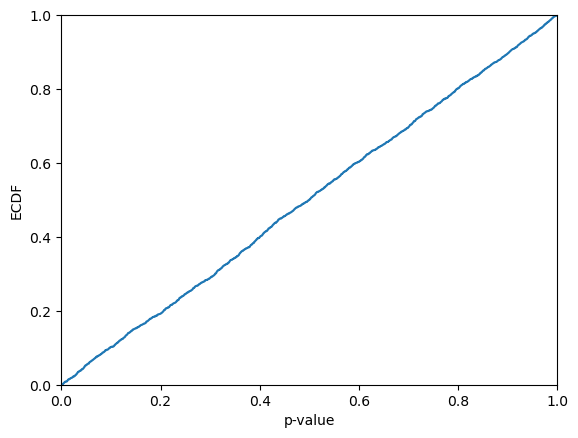

KS-test: 0.10638623750175547


In [118]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We can get the same result through `predict_cps` in the following way: 

In [119]:
p_values = cps_mond_norm.predict_cps(X_test, y=y_test, seed=123)

display(p_values)

array([0.75174948, 0.88777475, 0.21298863, ..., 0.96174913, 0.29422676,
       0.25497542])

If we instead would like to get threshold values, such that the probability for the true target is less than the threshold for each test instance, we may request these through `predict_percentiles` or by providing `lower_percentiles` and/or `upper_percentiles` as input to the `predict_cps` method. These denote (one or more) percentiles for which a lower (upper) value will be selected in case a percentile lies between two values (similar to `interpolation="lower"` and `interpolation="higher"` in `numpy.percentile`).

Here we will obtain the lowest values from `cps_mond_norm`, such that the probability for the target values being less than these is at least 50%, first using `predict_percentiles`:

In [120]:
thresholds = cps_mond_norm.predict_percentiles(X_test, higher_percentiles=50)

display(thresholds)

array([0.07711538, 0.05053219, 0.0798237 , ..., 0.03700809, 0.06872801,
       0.02668173])

Again, the same result can be obtained using the `predict_cps` method: 

In [121]:
thresholds = cps_mond_norm.predict_cps(X_test, higher_percentiles=50)

display(thresholds)

array([0.07711538, 0.05053219, 0.0798237 , ..., 0.03700809, 0.06872801,
       0.02668173])

For the `predict_cps` method, we can also specify both target values and percentiles; the resulting p-values will be returned in the first column, while any values corresponding to the lower percentiles will be included in the subsequent columns, followed by columns containing the values corresponding to the higher percentiles. The following call hence results in an array with five columns:

In [122]:
results = cps_mond_norm.predict_cps(X_test, y=y_test,
                                    lower_percentiles=[2.5, 5],
                                    higher_percentiles=[95, 97.5])

display(results)

array([[0.7518413 , 0.05975328, 0.063534  , 0.09171462, 0.0964323 ],
       [0.88746581, 0.03004174, 0.03559306, 0.06619671, 0.07237199],
       [0.21348939, 0.06176969, 0.06570108, 0.09500475, 0.09991044],
       ...,
       [0.96298644, 0.01194057, 0.01964534, 0.05314692, 0.05759479],
       [0.29505613, 0.05215455, 0.05576354, 0.08266412, 0.08716751],
       [0.25575831, 0.01432424, 0.01743067, 0.03249756, 0.0345924 ]])

In addition to p-values and threshold values, we can request that the conformal predictive system returns the full conformal predictive distribution (CPD) for each test instance, as defined by the threshold values, either by the `predict_cpds` method or by setting `return_cpds=True` for the `predict_cps` method . The format of the distributions vary with the type of conformal predictive system; for a standard and normalized CPS, the output is an array with a row for each test instance and a column for each calibration instance (residual), while for a Mondrian CPS, the default output is a vector containing one CPD per test instance (since the number of values may vary between categories). If the desired output instead is an array of distributions per category, where all distributions in a category have the same number of columns, which in turn depends on the number of calibration instances in the corresponding category, then `cpds_by_bins=True` may be specified (for both methods). In case `return_cpds=True` is specified together with `y`, `lower_percentiles` or `higher_percentiles`, the output of `predict` will be a pair, with the first element holding the results of the above type and the second element will contain the CPDs. 

For the above Mondrian CPS, the following call to `predict_cpds` will result in a vector of distributions, with one element for each test instance.

In [123]:
cpds = cps_mond_norm.predict_cpds(X_test)

print(f"No. of test instances: {len(X_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


The same result can be obtained with the following call to `predict_cps`:

In [124]:
cpds = cps_mond_norm.predict_cps(X_test, return_cpds=True)

print(f"No. of test instances: {len(X_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


If we instead would prefer to represent these distributions by one array per category, we set `cpds_by_bins=True`, noting that it will be a bit trickier to associate a test instance to a specific distribution.  

In [125]:
cpds = cps_mond_norm.predict_cps(X_test, return_cpds=True, cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2020 test instances, 541 threshold values
bin 1: 2375 test instances, 540 threshold values
bin 2: 2177 test instances, 540 threshold values
bin 3: 2114 test instances, 540 threshold values
bin 4: 2121 test instances, 541 threshold values
No. of test instances: 10807


We may also plot the conformal predictive distribution for some test object. In case the calibration set is very large, you may consider plotting an approximation of the full distribution by using a grid of values for `lower_percentiles` or `higher_percentiles`, instead of setting `return_cpds=True`. For the Mondrian CPS, the size of the calibration set for each bin is reasonable in this case, so we may just use the distributions directly.

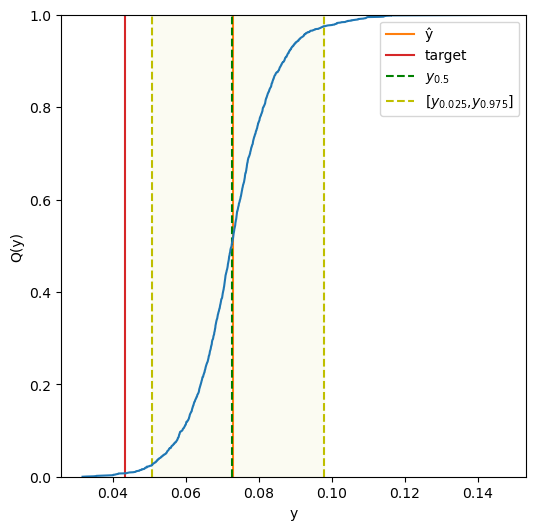

In [126]:
cpds = cps_mond_norm_oob.predict_cps(X_test, return_cpds=True)

test_index = np.random.randint(len(X_test)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(6,6))

y_hat = cps_mond_norm_oob.predict(X_test[test_index][None,:])

plt.plot([y_hat,y_hat],[0,1], color="tab:orange")
plt.plot([y_test[test_index],y_test[test_index]],[0,1], color="tab:red")
plt.xlabel("y")
plt.ylabel("Q(y)")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
plt.plot(cpd,p, color="tab:blue")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y", 
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

### Investigating the coverage and size of extracted prediction intervals

Let us investigate the extracted prediction intervals at the 95% confidence level. 
This is done by a specifying percentiles corresponding to the interval endpoints.

In [127]:
all_cps = {"Std CPS":cps_std,
           "Std OOB CPS":cps_std_oob,
           "Norm CPS":cps_norm,
           "Norm OOB CPS":cps_norm_oob,
           "Mond CPS":cps_mond_std,
           "Mond OOB CPS":cps_mond_std_oob,
           "Mond norm CPS":cps_mond_norm,
           "Mond norm OOB CPS":cps_mond_norm_oob
          }

all_cps_intervals = {}

coverages = []
mean_sizes = []
median_sizes = []

for name in all_cps.keys():
    intervals = all_cps[name].predict_int(X_test, y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(all_cps_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CPS,0.9548,0.0662,0.0674
Std OOB CPS,0.9538,0.0631,0.0643
Norm CPS,0.9506,0.0599,0.0470
Norm OOB CPS,0.9489,0.0505,0.0384
Mond CPS,0.9493,0.0596,0.0452
Mond OOB CPS,0.9455,0.0564,0.0388
Mond norm CPS,0.9536,0.0627,0.0444
Mond norm OOB CPS,0.9473,0.0520,0.0360
Mean,0.9505,0.0588,0.0477


### Investigating the distributions of extracted prediction intervals

Let us take a look at the distribution of the interval sizes.

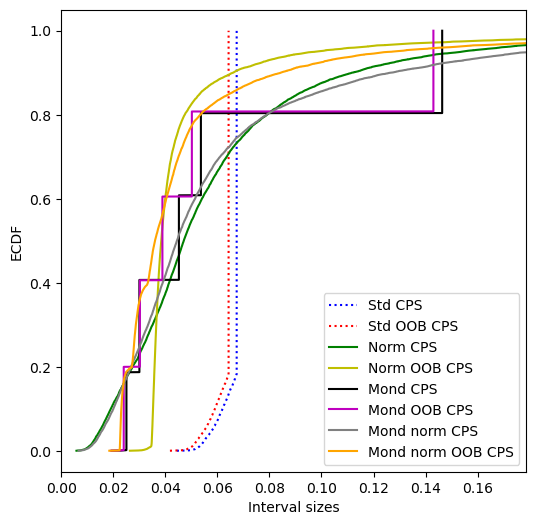

In [128]:
cps_interval_sizes = {}

for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = \
    all_cps_intervals[name][:,1] - all_cps_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Mond OOB CPS"].max()*1.25)

colors = ["b","r","g","y","k","m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(cps_interval_sizes[name]),
             [i/len(cps_interval_sizes[name])
              for i in range(1,len(cps_interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Extracting medians

Let us take a look at the medians; they can be derived using either lower or higher interpolation,
but ideally the differences should be small.

In [129]:
all_cps_medians = {}

for name in all_cps.keys():
    medians = all_cps[name].predict_cps(X_test, 
                                        lower_percentiles=50, 
                                        higher_percentiles=50)
    all_cps_medians[name] = medians
    print(name)
    print("\tMean difference of the medians:    {:.6f}".format((medians[:,1]-medians[:,0]).mean()))
    print("\tLargest difference of the medians: {:.6f}".format((medians[:,1]-medians[:,0]).max()))

Std CPS
	Mean difference of the medians:    0.000006
	Largest difference of the medians: 0.000006
Std OOB CPS
	Mean difference of the medians:    0.000002
	Largest difference of the medians: 0.000002
Norm CPS
	Mean difference of the medians:    0.000023
	Largest difference of the medians: 0.000185
Norm OOB CPS
	Mean difference of the medians:    0.000001
	Largest difference of the medians: 0.000038
Mond CPS
	Mean difference of the medians:    0.000007
	Largest difference of the medians: 0.000024
Mond OOB CPS
	Mean difference of the medians:    0.000012
	Largest difference of the medians: 0.000045
Mond norm CPS
	Mean difference of the medians:    0.000018
	Largest difference of the medians: 0.000320
Mond norm OOB CPS
	Mean difference of the medians:    0.000011
	Largest difference of the medians: 0.000795


### Another view of the medians and prediction intervals

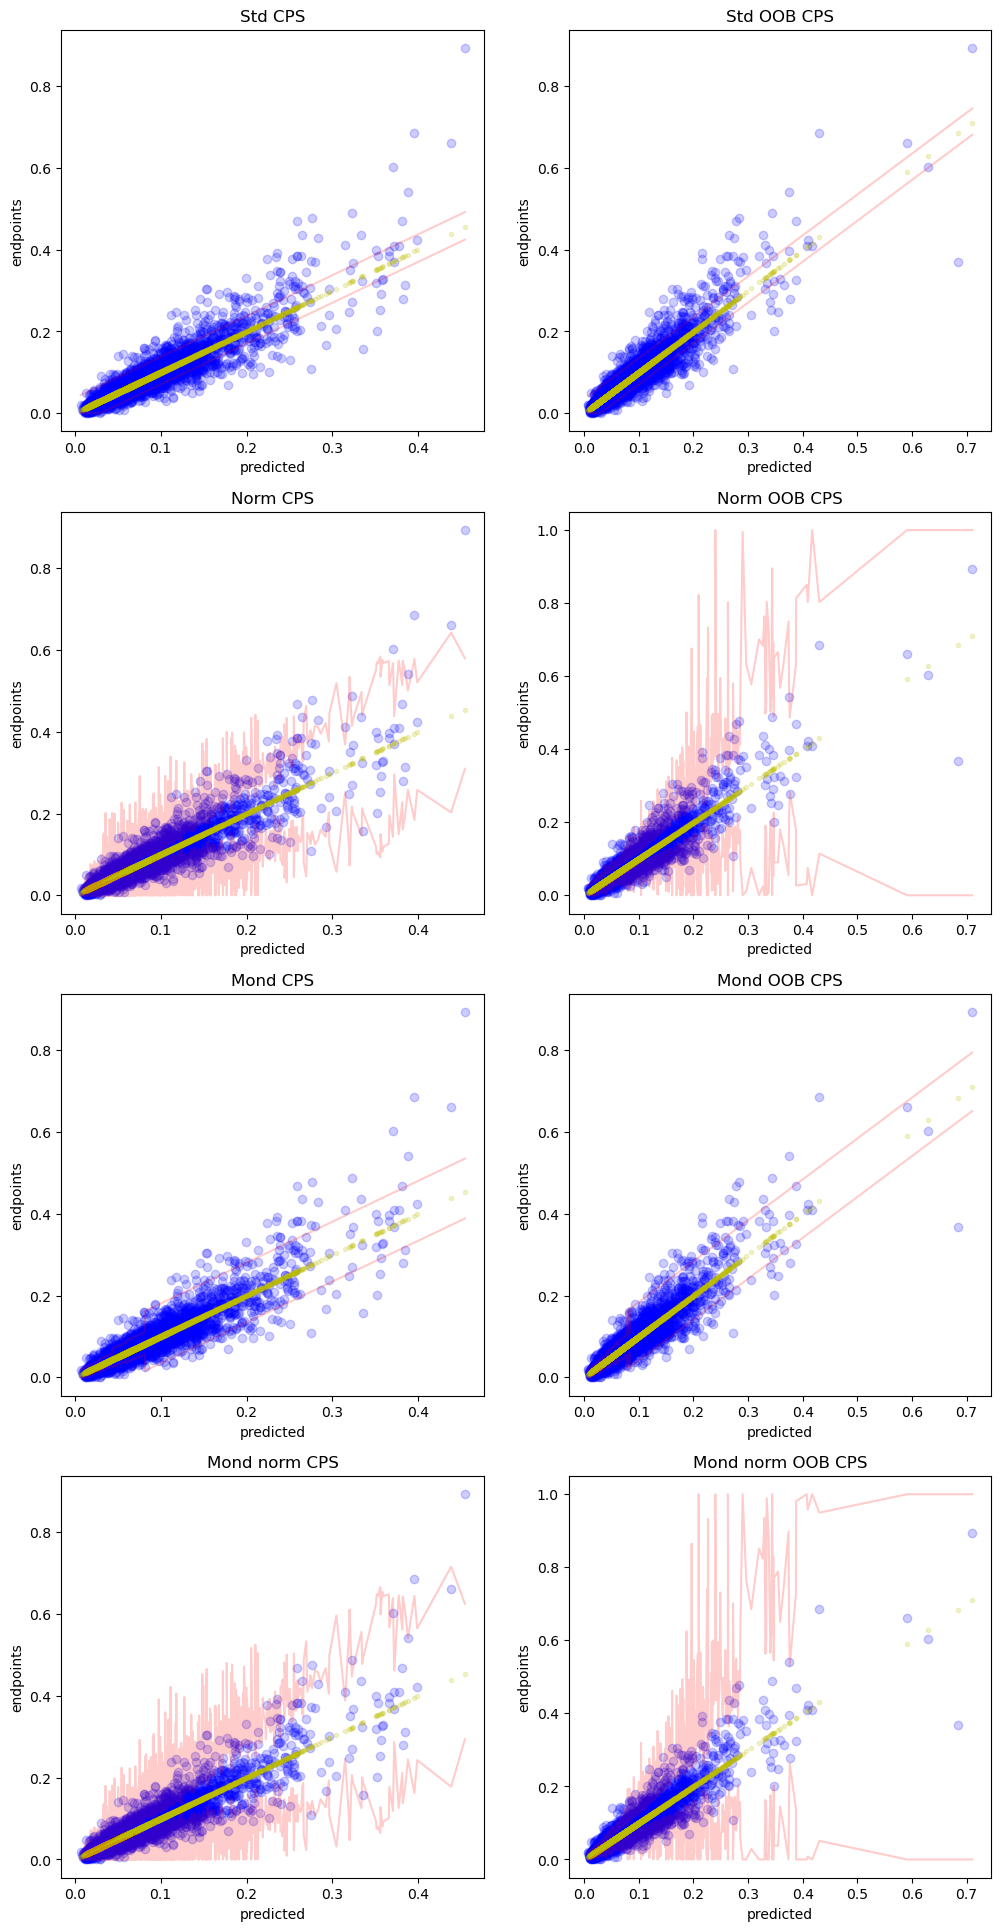

In [130]:
y_hat_test = learner_prop.predict(X_test)
y_hat_full = learner_full.predict(X_test)

plt.subplots(len(all_cps_intervals.keys())//2,2,figsize=(12,24))

sorted_prop_indexes = np.argsort(y_hat_test) 

sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(all_cps_intervals.keys()):

    plt.subplot(len(all_cps_intervals.keys())//2,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat_ = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat_ = y_hat_test

    plt.title(name)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,0], 
             color="r", alpha=alpha)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,1], 
             color="r", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_test[indexes],
                color="b", marker="o", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_hat_[indexes],
                color="y", marker=".", alpha=alpha)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

### Evaluating the CPS using a test set

Let us evaluate the generated CPS using three confidence levels on the test set.
We could specify a subset of the metrics to use by the
`metrics` parameter of the `evaluate` method; here we use all metrics, 
which is the default

Note that `bins` can always be provided, but they will be ignored by CPS that 
have not been fitted with such, i.e., the CPS is not of the Mondrian type.

Note that CRPS takes some time to compute, in particular when the CPS have been 
fitted with larger calibration sets.

In [131]:
confidence_levels = [0.9,0.95,0.99]

names = np.array(list(all_cps.keys()))

first_set = names[["OOB" not in name for name in names]]
second_set = names[["OOB" in name for name in names]]

for methods in [first_set, second_set]:
    all_cps_results = {}
    for confidence in confidence_levels:
        for name in methods:
            all_cps_results[(name,confidence)] = all_cps[name].evaluate(
                    X_test, y=y_test, confidence=confidence, 
                    y_min=0, y_max=1)

    cps_results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
        [methods,confidence_levels]), index=list(list(
        all_cps_results.values())[0].keys()))

    for key in all_cps_results.keys():
        cps_results_df[key] = all_cps_results[key].values()

    display(cps_results_df.round(4))

Std CPS                 Norm CPS                 Mond CPS  \
                 0.90    0.95    0.99     0.90    0.95    0.99     0.90   
error          0.0998  0.0489  0.0098   0.1013  0.0512  0.0081   0.1020   
eff_mean       0.0422  0.0628  0.1296   0.0451  0.0592  0.0972   0.0429   
eff_med        0.0424  0.0639  0.1330   0.0352  0.0464  0.0773   0.0301   
time_fit       0.0002  0.0002  0.0002   0.0001  0.0001  0.0001   0.0007   
ks_test        0.5752  0.5752  0.5752   0.6970  0.6970  0.6970   0.6117   
time_evaluate  0.1664  0.1314  0.1265   0.1188  0.1454  0.1406   0.0718   

                              Mond norm CPS                  
                 0.95    0.99          0.90    0.95    0.99  
error          0.0501  0.0098        0.1012  0.0488  0.0082  
eff_mean       0.0592  0.1117        0.0467  0.0613  0.1042  
eff_med        0.0415  0.0694        0.0338  0.0440  0.0728  
time_fit       0.0007  0.0007        0.0008  0.0008  0.0008  
ks_test        0.6117  0.6117        0.5664  0.5664  0.5664  
time_evaluate  0.0713  0.1019        0.0821  0.0956  0.0929

Std OOB CPS                 Norm OOB CPS                  \
                     0.90    0.95    0.99         0.90    0.95    0.99   
error              0.0995  0.0482  0.0099       0.1043  0.0517  0.0096   
eff_mean           0.0414  0.0620  0.1278       0.0385  0.0504  0.0790   
eff_med            0.0416  0.0630  0.1325       0.0291  0.0383  0.0608   
time_fit           0.0005  0.0005  0.0005       0.0001  0.0001  0.0001   
ks_test            0.2726  0.2726  0.2726       0.2117  0.2117  0.2117   
time_evaluate      0.2102  0.1761  0.1733       0.1700  0.1717  0.1654   

              Mond OOB CPS                 Mond norm OOB CPS                  
                      0.90    0.95    0.99              0.90    0.95    0.99  
error               0.1035  0.0530  0.0101            0.1045  0.0511  0.0104  
eff_mean            0.0420  0.0567  0.0961            0.0415  0.0522  0.0794  
eff_med             0.0296  0.0388  0.0668            0.0281  0.0361  0.0609  
time_fit            0.0003  0.0003  0.0003            0.0005  0.0005  0.0005  
ks_test             0.2218  0.2218  0.2218            0.1952  0.1952  0.1952  
time_evaluate       0.0878  0.0840  0.0837            0.0872  0.0880  0.0843

### Semi-online conformal predictive systems

Similar to semi-online conformal regressors and classifiers, we may consider employing *online calibration* also for conformal predictive systems, i.e., continuously updating the calibration set after making each prediction. This is achieved by setting `online=True` when calling the methods `predict_p`, `predict_int`, `predict_percentiles`, `predict_cpds`,  and `evaluate`.

#### Online calibration with calibrated conformal predictive systems

Here we will obtain p-values computed in an online fashion for some of the above calibrated conformal predictive systems. Note that in addition to the test objects, we also need to provide the correct labels.

Std CPS
KS-test: 0.5962803463185213


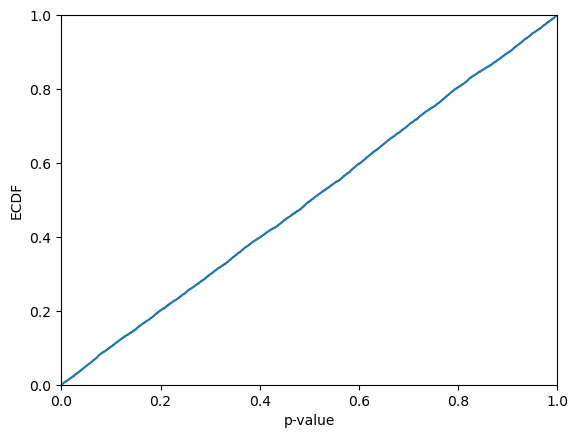

Norm CPS
KS-test: 0.7102578812667508


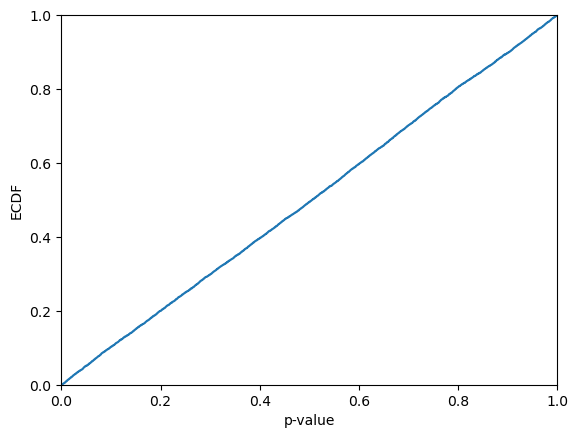

Mond CPS
KS-test: 0.5552349214807512


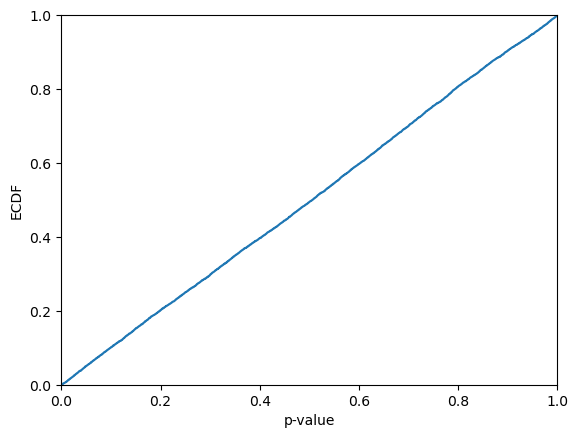

Mond norm CPS
KS-test: 0.6179750177751291


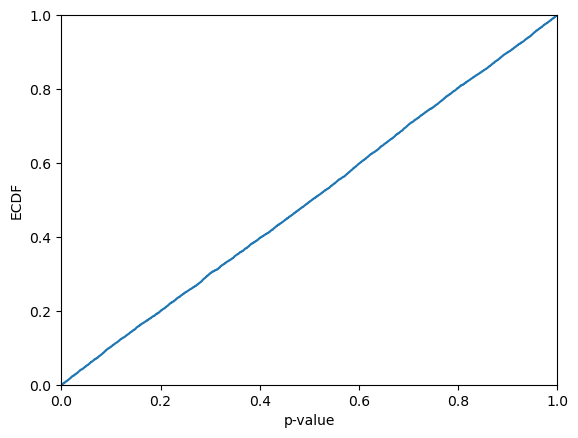

In [132]:
for cps in first_set:
    print(cps)
    p_values = all_cps[cps].predict_p(X_test, y_test, online=True)
    print(f"KS-test: {kstest(p_values, "uniform").pvalue}")
    plt.ecdf(p_values)
    plt.xlim(0,1)
    plt.xlabel("p-value")
    plt.ylabel("ECDF")
    plt.show()

Similarly, we can obtain prediction intervals using online calibration:

In [133]:
cps_std.predict_int(X_test, y_test, online=True)

array([[ 0.04787515,  0.11526344],
       [ 0.02142412,  0.08881241],
       [ 0.05060496,  0.11799325],
       ...,
       [ 0.00737904,  0.07128304],
       [ 0.03943405,  0.10333805],
       [-0.00277473,  0.06112927]])

In [134]:
cps_norm.predict_int(X_test, y_test, online=True)

array([[0.05604126, 0.09637615],
       [0.02645218, 0.07264332],
       [0.05790973, 0.09985205],
       ...,
       [0.01109987, 0.06127579],
       [0.04937624, 0.08758631],
       [0.01789748, 0.03546998]])

In [135]:
cps_mond_std.predict_int(X_test, y_test, online=True)

array([[0.05308445, 0.10671735],
       [0.03205985, 0.07723537],
       [0.05581426, 0.10944716],
       ...,
       [0.02155846, 0.05330625],
       [0.04449723, 0.09811713],
       [0.01394607, 0.0382353 ]])

In [136]:
cps_mond_norm.predict_int(X_test, y_test, online=True)

array([[0.05975328, 0.0964323 ],
       [0.03004174, 0.07237199],
       [0.06176969, 0.09991044],
       ...,
       [0.01161363, 0.0582614 ],
       [0.05184458, 0.08812224],
       [0.01579513, 0.03496522]])

We can also get (lower and higher) percentiles using online calibration:

In [137]:
cps_std.predict_percentiles(X_test, y_test, 
                            lower_percentiles = [2.5, 25],
                            higher_percentiles = [50, 75, 97.5],
                            y_min=0, y_max=1, online=True)

array([[0.04787515, 0.07123022, 0.07708466, 0.08224582, 0.11526344],
       [0.02142412, 0.04479082, 0.05063363, 0.05577722, 0.08881241],
       [0.05060496, 0.07397166, 0.07982421, 0.08497562, 0.11799325],
       ...,
       [0.00737904, 0.03091324, 0.03665321, 0.04169801, 0.07128304],
       [0.03943405, 0.06296883, 0.06870822, 0.07375302, 0.10333805],
       [0.        , 0.02076005, 0.02649944, 0.03154424, 0.06112927]])

In [138]:
cps_norm.predict_percentiles(X_test, y_test, 
                             lower_percentiles = [2.5, 25],
                             higher_percentiles = [50, 75, 97.5],
                             y_min=0, y_max=1, online=True)

array([[0.05604126, 0.07197938, 0.07715928, 0.08170414, 0.09637615],
       [0.02645218, 0.04470513, 0.05063634, 0.05584107, 0.07264332],
       [0.05790973, 0.07448371, 0.07988571, 0.08460066, 0.09985205],
       ...,
       [0.01109987, 0.0302245 , 0.03654571, 0.04226749, 0.06127579],
       [0.04937624, 0.06394102, 0.06875381, 0.07311107, 0.08758631],
       [0.01789748, 0.0245957 , 0.02680906, 0.02881293, 0.03546998]])

In [139]:
cps_mond_std.predict_percentiles(X_test, y_test, 
                                 lower_percentiles = [2.5, 25],
                                 higher_percentiles = [50, 75, 97.5],
                                 y_min=0, y_max=1, online=True)

array([[0.05308445, 0.069342  , 0.07671758, 0.08403515, 0.10671735],
       [0.03205985, 0.04515901, 0.05051634, 0.05615443, 0.07723537],
       [0.05581426, 0.07207181, 0.07944739, 0.08676496, 0.10944716],
       ...,
       [0.02155846, 0.03300713, 0.03694911, 0.04072134, 0.05330625],
       [0.04449723, 0.06135048, 0.06825908, 0.07542132, 0.09811713],
       [0.01394607, 0.02320803, 0.02676756, 0.02946943, 0.0382353 ]])

In [140]:
cps_mond_norm.predict_percentiles(X_test, y_test,
                                  lower_percentiles = [2.5, 25],
                                  higher_percentiles = [50, 75, 97.5],
                                  y_min=0, y_max=1, online=True)

array([[0.05975328, 0.07202332, 0.07711538, 0.08183104, 0.0964323 ],
       [0.03004174, 0.04544445, 0.05053219, 0.05500278, 0.07237199],
       [0.06176969, 0.07452872, 0.0798237 , 0.08486889, 0.09991044],
       ...,
       [0.01161363, 0.03123941, 0.0368722 , 0.04191775, 0.0582614 ],
       [0.05184458, 0.06409599, 0.06867258, 0.07303321, 0.08812224],
       [0.01579513, 0.02400104, 0.02682975, 0.02901168, 0.03496522]])

We can also obtain the full conformal predictive distributions (cpds) using online calibration. For standard and normalized conformal predictive systems, each cpd will contain one more value than the preceding, since the calibration set is growing by one element for each prediction.

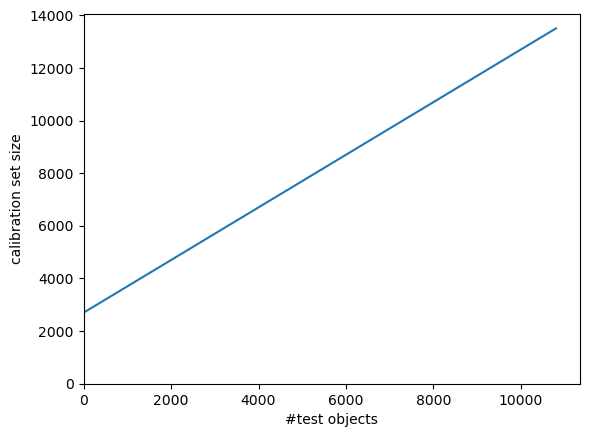

In [141]:
cpds = cps_norm.predict_cpds(X_test, y_test, online=True)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

For Mondrian conformal predictive systems, the calibration set for one of the categories will be extended with one element for each prediction; the size of the predicted cpd is dependent on which category the test object falls in.

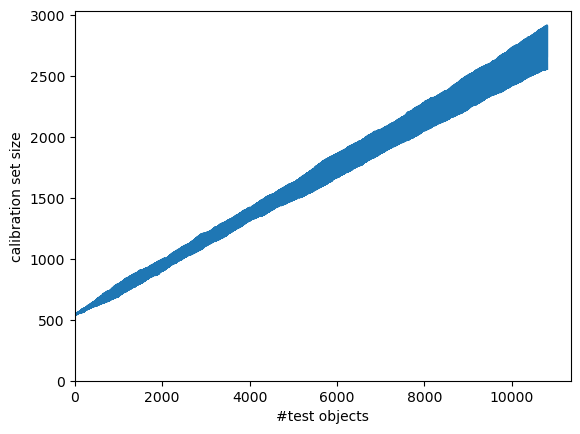

In [142]:
cpds = cps_mond_norm.predict_cpds(X_test, y_test, online=True)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when fitting the conformal regressor. We may set the `warm_start` option to `False`, if we would like to ignore the original calibration set. Note that the initial predictions tend to be very (maximally) wide, before we have a sufficiently large calibration set to allow for providing tighter intervals at the specified level of confidence.

In [143]:
cps_std.predict_int(X_test, y_test, online=True, warm_start=False)

array([[       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf],
       ...,
       [ 0.00728605,  0.07035561],
       [ 0.03934106,  0.10241062],
       [-0.00286772,  0.06020184]])

In [144]:
cps_norm.predict_int(X_test, y_test, online=True, warm_start=False)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.01123974, 0.06145531],
       [0.04948275, 0.08772302],
       [0.01794646, 0.03553285]])

In [145]:
cps_mond_std.predict_int(X_test, y_test, online=True, warm_start=False)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02124808, 0.05362491],
       [0.0442988 , 0.09821379],
       [0.01379224, 0.0381352 ]])

In [146]:
cps_mond_norm.predict_int(X_test, y_test, online=True, warm_start=False)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.01161026, 0.05861562],
       [0.05153434, 0.08833175],
       [0.01584102, 0.03514241]])

Similarly, we can request percentiles while disabling `warm_start` for online calibration:

In [147]:
cps_std.predict_percentiles(X_test, y_test, 
                            lower_percentiles = [2.5, 25],
                            higher_percentiles = [50, 75, 97.5],
                            y_min=0, y_max=1, 
                            online=True, warm_start=False)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.05551618, 1.        , 1.        ],
       [0.        , 0.        , 0.09015789, 1.        , 1.        ],
       ...,
       [0.00728605, 0.03097585, 0.03666226, 0.04169251, 0.07035561],
       [0.03934106, 0.06303086, 0.06871727, 0.07374803, 0.10241062],
       [0.        , 0.02082208, 0.0265085 , 0.03153925, 0.06020184]])

When disabling `warm_start`, we can observe that size of the cpd (= size of the calibration set) is initially zero:

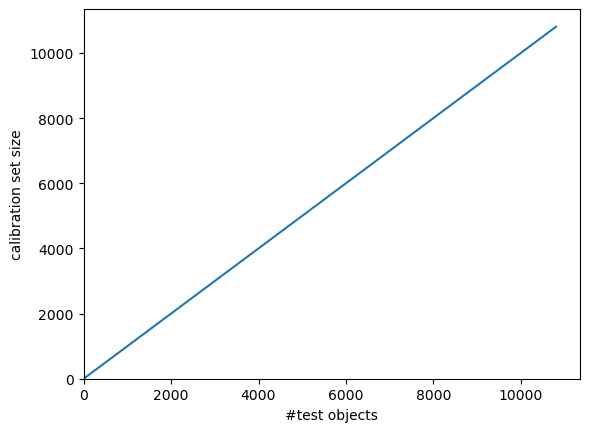

In [148]:
cpds = cps_norm.predict_cpds(X_test, y_test, online=True, warm_start=False)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

Similarly for Mondrian conformal predictive systems:

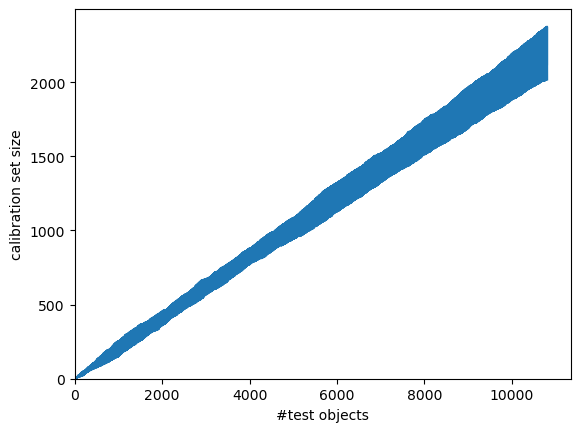

In [149]:
cpds = cps_mond_norm.predict_cpds(X_test, y_test, online=True, warm_start=False)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

We may also evaluate the conformal predictive systems using online calibration, by specifying `online=True` for the `evaluate` method:

In [150]:
cps_std.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                 online=True)

{'error': 0.009808457481262134,
 'eff_mean': 0.12957579238578523,
 'eff_med': 0.13303423186885244,
 'time_fit': 0.00016021728515625,
 'ks_test': 0.5751564855532147,
 'time_evaluate': 0.11733746528625488}

In [151]:
cps_norm.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                  online=True)

{'error': 0.008050337744054725,
 'eff_mean': 0.09718410114669333,
 'eff_med': 0.07732296021173327,
 'time_fit': 0.00010085105895996094,
 'ks_test': 0.6969522935470824,
 'time_evaluate': 0.11350369453430176}

In [152]:
cps_mond_std.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                      online=True)

{'error': 0.009808457481262134,
 'eff_mean': 0.11171693610561466,
 'eff_med': 0.06939848891803273,
 'time_fit': 0.0006766319274902344,
 'ks_test': 0.6116867409848821,
 'time_evaluate': 0.0751335620880127}

In [153]:
cps_mond_norm.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                       online=True)

{'error': 0.008235402979550277,
 'eff_mean': 0.10420182711656334,
 'eff_med': 0.07276971379532549,
 'time_fit': 0.0007817745208740234,
 'ks_test': 0.5664371560997962,
 'time_evaluate': 0.07816386222839355}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [154]:
cps_mond_norm.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                       online=True, warm_start=False)

{'error': 0.005274359211622115,
 'eff_mean': 0.12011788694232399,
 'eff_med': 0.0852867736164448,
 'time_fit': 0.0007817745208740234,
 'CRPS': 0.007030363971560898,
 'ks_test': 0.04559119572615944,
 'time_evaluate': 0.37314915657043457}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the underlying model. 

In [155]:
rf_full = WrapRegressor(RandomForestRegressor(n_jobs=-1, n_estimators=500))

rf_full.fit(X_train, y_train)

Let us first initialize the conformal predictive system with an empty calibration set, i.e., not specifying any objects or labels for the `calibrate` method, but just setting `cps=True` (as we will see further below, we may additionally provide parameters such as difficulty estimator, Mondrian categorizer, etc.):

In [156]:
rf_full.calibrate(cps=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1), calibrated=False)

We may now obtain prediction intervals while sequentially updating the calibration set:

In [157]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.01785395, 0.05922435],
       [0.0493198 , 0.0906902 ],
       [0.00719896, 0.04856936]])

Let us investigate also the p-values:

array([0.1428238 , 0.0259196 , 0.74812542, ..., 0.07030082, 0.71222233,
       0.66332484])

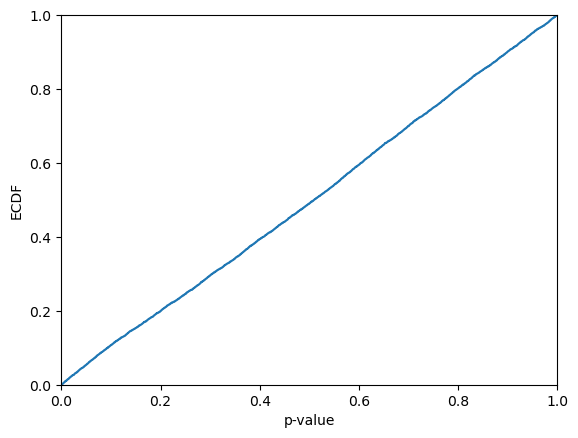

KS-test: 0.1934153416570974


In [158]:
p_values = rf_full.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

If we provide also a difficulty estimator to `calibrate`, we will obtain a normalized conformal predictive system:

In [159]:
de_var = DifficultyEstimator()
de_var.fit(X=X_train, learner=rf_full.learner, scaler=True)

rf_full.calibrate(de=de_var, cps=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1), calibrated=False)

Now we get the intervals in the usual way:

In [160]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02426831, 0.05333176],
       [0.052767  , 0.08801168],
       [0.01374864, 0.04253788]])

Let us investigate also the p-values:

array([0.10247823, 0.26073051, 0.98338702, ..., 0.0424165 , 0.69378292,
       0.67831493])

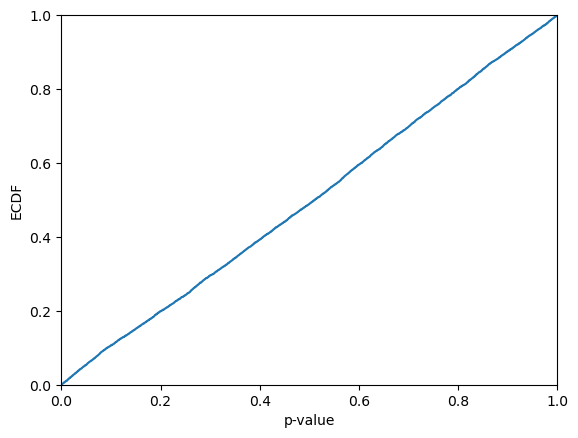

KS-test: 0.1016922037284812


In [161]:
p_values = rf_full.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We get a Mondrian conformal predictive system by providing a Mondrian categorizer to `calibrate`:

In [162]:
mc = MondrianCategorizer()
mc.fit(X_cal, de=de_var, no_bins=10)

rf_full.calibrate(mc=mc, cps=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1), calibrated=False)

We use the same call again to get the intervals from the Mondrian conformal predictive system:

In [163]:
rf_full.predict_int(X_test, y_test, confidence=0.9, online=True)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02510731, 0.05171442],
       [0.04995927, 0.0952166 ],
       [0.01445232, 0.0411108 ]])

Let us investigate the coverage and prediction interval size for each category (here limiting the lower and upper bounds of the intervals):

In [164]:
prediction_intervals = rf_full.predict_int(X_test, y_test, y_min=0, 
                                           y_max=1, confidence=0.99,
                                           online=True)
number = []
coverage = []
size = []

bins_test = mc.apply(X_test)

for c in range(len(mc.bin_thresholds)-1):
    selection = bins_test == c
    number.append(np.sum(selection))
    coverage.append(np.sum(
        (prediction_intervals[selection,0] <= y_test[selection])& \
        (y_test[selection] <= prediction_intervals[selection,1]))/np.sum(selection))
    size.append(np.sum(prediction_intervals[selection,1]-\
                       prediction_intervals[selection,0])/np.sum(selection))

df = pd.DataFrame({"Number":number, "Coverage":coverage, "Size":size})
df.round(4)

,Number,Coverage,Size
0,147,1.0000,1.0000
1,537,0.9963,0.3891
2,679,0.9926,0.3142
3,733,0.9945,0.2959
4,983,0.9858,0.2265
5,1148,0.9939,0.2152
6,1283,0.9883,0.1985
7,1634,0.9920,0.1835
8,1969,0.9924,0.1872
9,1694,0.9965,0.3670


Let us investigate also the p-values:

array([0.53214714, 0.43778192, 0.03993967, ..., 0.02242697, 0.63007498,
       0.67977321])

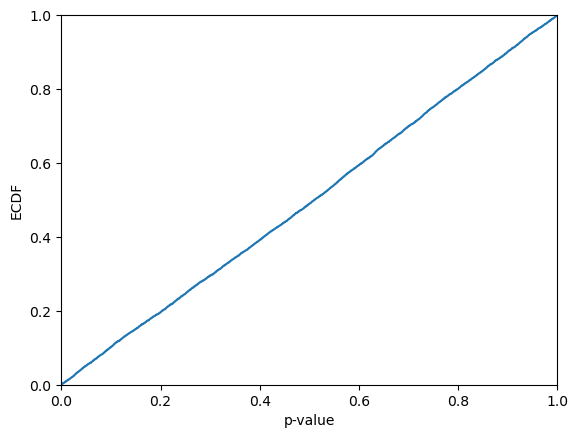

KS-test: 0.10544072348439648


In [165]:
p_values = rf_full.predict_p(X_test, y_test, online=True)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

Similarly, we can also request percentiles using online calibration:

In [166]:
rf_full.predict_percentiles(X_test, y_test, 
                            lower_percentiles = [2.5, 25],
                            higher_percentiles = [50, 75, 97.5],
                            y_min=0, y_max=1, online=True)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       ...,
       [0.0224026 , 0.03304831, 0.03768926, 0.04268077, 0.05384568],
       [0.04447137, 0.06129608, 0.06858073, 0.07719714, 0.10112838],
       [0.01174761, 0.02239332, 0.02704832, 0.03206945, 0.04329931]])

We can of course also request the cpds; here we take a close look at those belonging to category 5:

In [167]:
cpds = rf_full.predict_cpds(X_test, y_test, online=True)

cpds[bins_test == 5]

array([array([], dtype=float64), array([0.03971966]),
       array([0.03241696, 0.04000547]), ...,
       array([-0.00564027,  0.00130014,  0.00366736, ...,  0.0589863 ,
               0.06150993,  0.06468008])                              ,
       array([0.01863575, 0.02557616, 0.02794338, ..., 0.08326232, 0.08578595,
              0.0889561 ])                                                    ,
       array([-0.00226413,  0.00467628,  0.0070435 , ...,  0.06236244,
               0.06488607,  0.06805622])                              ],
      dtype=object)

We may also evaluate the conformal predictive system using online calibration, by specifying `online=True` for the `evaluate` method:

In [168]:
rf_full.evaluate(X_test, y_test, confidence=0.99, y_min=0, y_max=1, online=True)

{'error': 0.007495142037568292,
 'eff_mean': 0.25916496104626785,
 'eff_med': 0.07428075960655742,
 'time_fit': 7.867813110351562e-06,
 'ks_test': 0.006618064524288634,
 'time_evaluate': 0.07439303398132324}